# Домашнее задание №1

## ИУ5-23 Зорин Арсений

## Решение комплексной задачи машинного обучения с учителем.¶

### Предсказание стоимости ноутбука на основе его характеристик.

In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import scipy.stats as stats
from supervised.automl import AutoML

import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_palette('husl')

data = pd.read_csv('../datasets/laptop/laptop_price.csv', encoding = "ISO-8859-1")
data = data.set_index('laptop_ID')
data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## Обработка нестандартных признаков

In [13]:
data["Ram"] = data["Ram"].str.replace('GB', '')
data["Weight"] = data["Weight"].str.replace('kg', '')
data['Memory'] = data['Memory'].astype(str).replace('\.0', '', regex=True)
data["Memory"] = data["Memory"].str.replace('GB', '')
data["Memory"] = data["Memory"].str.replace('TB', '000')
new2 = data["Memory"].str.split("+", n = 1, expand = True)
data["first"]= new2[0]
data["first"]=data["first"].str.strip()
data["second"]= new2[1]
data["Layer1HDD"] = data["first"].apply(lambda x: 1 if "HDD" in x else 0)
data["Layer1SSD"] = data["first"].apply(lambda x: 1 if "SSD" in x else 0)
data["Layer1Hybrid"] = data["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
data["Layer1Flash_Storage"] = data["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)
data['first'] = data['first'].str.replace(r'\D', '')
data["second"].fillna("0", inplace = True)
data["Layer2HDD"] = data["second"].apply(lambda x: 1 if "HDD" in x else 0)
data["Layer2SSD"] = data["second"].apply(lambda x: 1 if "SSD" in x else 0)
data["Layer2Hybrid"] = data["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
data["Layer2Flash_Storage"] = data["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)
data['second'] = data['second'].str.replace(r'\D', '')
data["first"] = data["first"].astype(int)
data["second"] = data["second"].astype(int)
data["Total_Memory"]=(data["first"]*(data["Layer1HDD"]+data["Layer1SSD"]+data["Layer1Hybrid"]+data["Layer1Flash_Storage"])+data["second"]*(data["Layer2HDD"]+data["Layer2SSD"]+data["Layer2Hybrid"]+data["Layer2Flash_Storage"]))
data["Memory"]=data["Total_Memory"]
data["HDD"]=(data["first"]*data["Layer1HDD"]+data["second"]*data["Layer2HDD"])
data["SSD"]=(data["first"]*data["Layer1SSD"]+data["second"]*data["Layer2SSD"])
data["Hybrid"]=(data["first"]*data["Layer1Hybrid"]+data["second"]*data["Layer2Hybrid"])
data["Flash_Storage"]=(data["first"]*data["Layer1Flash_Storage"]+data["second"]*data["Layer2Flash_Storage"])
new = data["ScreenResolution"].str.split("x", n = 1, expand = True) 
data["X_res"]= new[0]
data["Y_res"]= new[1]
data["Y_res"]= pd.to_numeric(data["Y_res"])
data["Y_res"]= data["Y_res"].astype(float)
data["X_res"]=(data['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int)).mean(1))
data["X_res"]=pd.to_numeric(data["X_res"])
data["PPI"]=(((data["X_res"]**2+data["Y_res"]**2)**(1/2))/data["Inches"]).astype(float)
data["ScreenResolution"]=(data["X_res"]*data["Y_res"]).astype(float)
data["Ram"] = data["Ram"].astype(int)
data["Weight"] = data["Weight"].astype(float)
data=data.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1)

data['Weight'], _ = stats.yeojohnson(data['Weight'])

cat_cols = ['Company', 'Product', 'TypeName', 'Cpu', 'Gpu', 'OpSys']
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

In [14]:
data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Hybrid,Flash_Storage,X_res,Y_res,PPI
laptop_ID,,,,,,,,,,,,,,,,,,,
1,1,300,4,13.3,4096000.0,65,8,128,58,8,0.706773,1339.69,0,128,0,0,2560.0,1600.0,226.983005
2,1,301,4,13.3,1296000.0,63,8,128,51,8,0.698321,898.94,0,0,0,128,1440.0,900.0,127.677940
3,7,50,3,15.6,2073600.0,74,8,256,53,4,0.825642,575.00,0,256,0,0,1920.0,1080.0,141.211998
4,1,300,4,15.4,5184000.0,85,16,512,9,8,0.819252,2537.45,0,512,0,0,2880.0,1800.0,220.534624
5,1,300,4,13.3,4096000.0,67,8,256,59,8,0.706773,1803.60,0,256,0,0,2560.0,1600.0,226.983005


<AxesSubplot:>

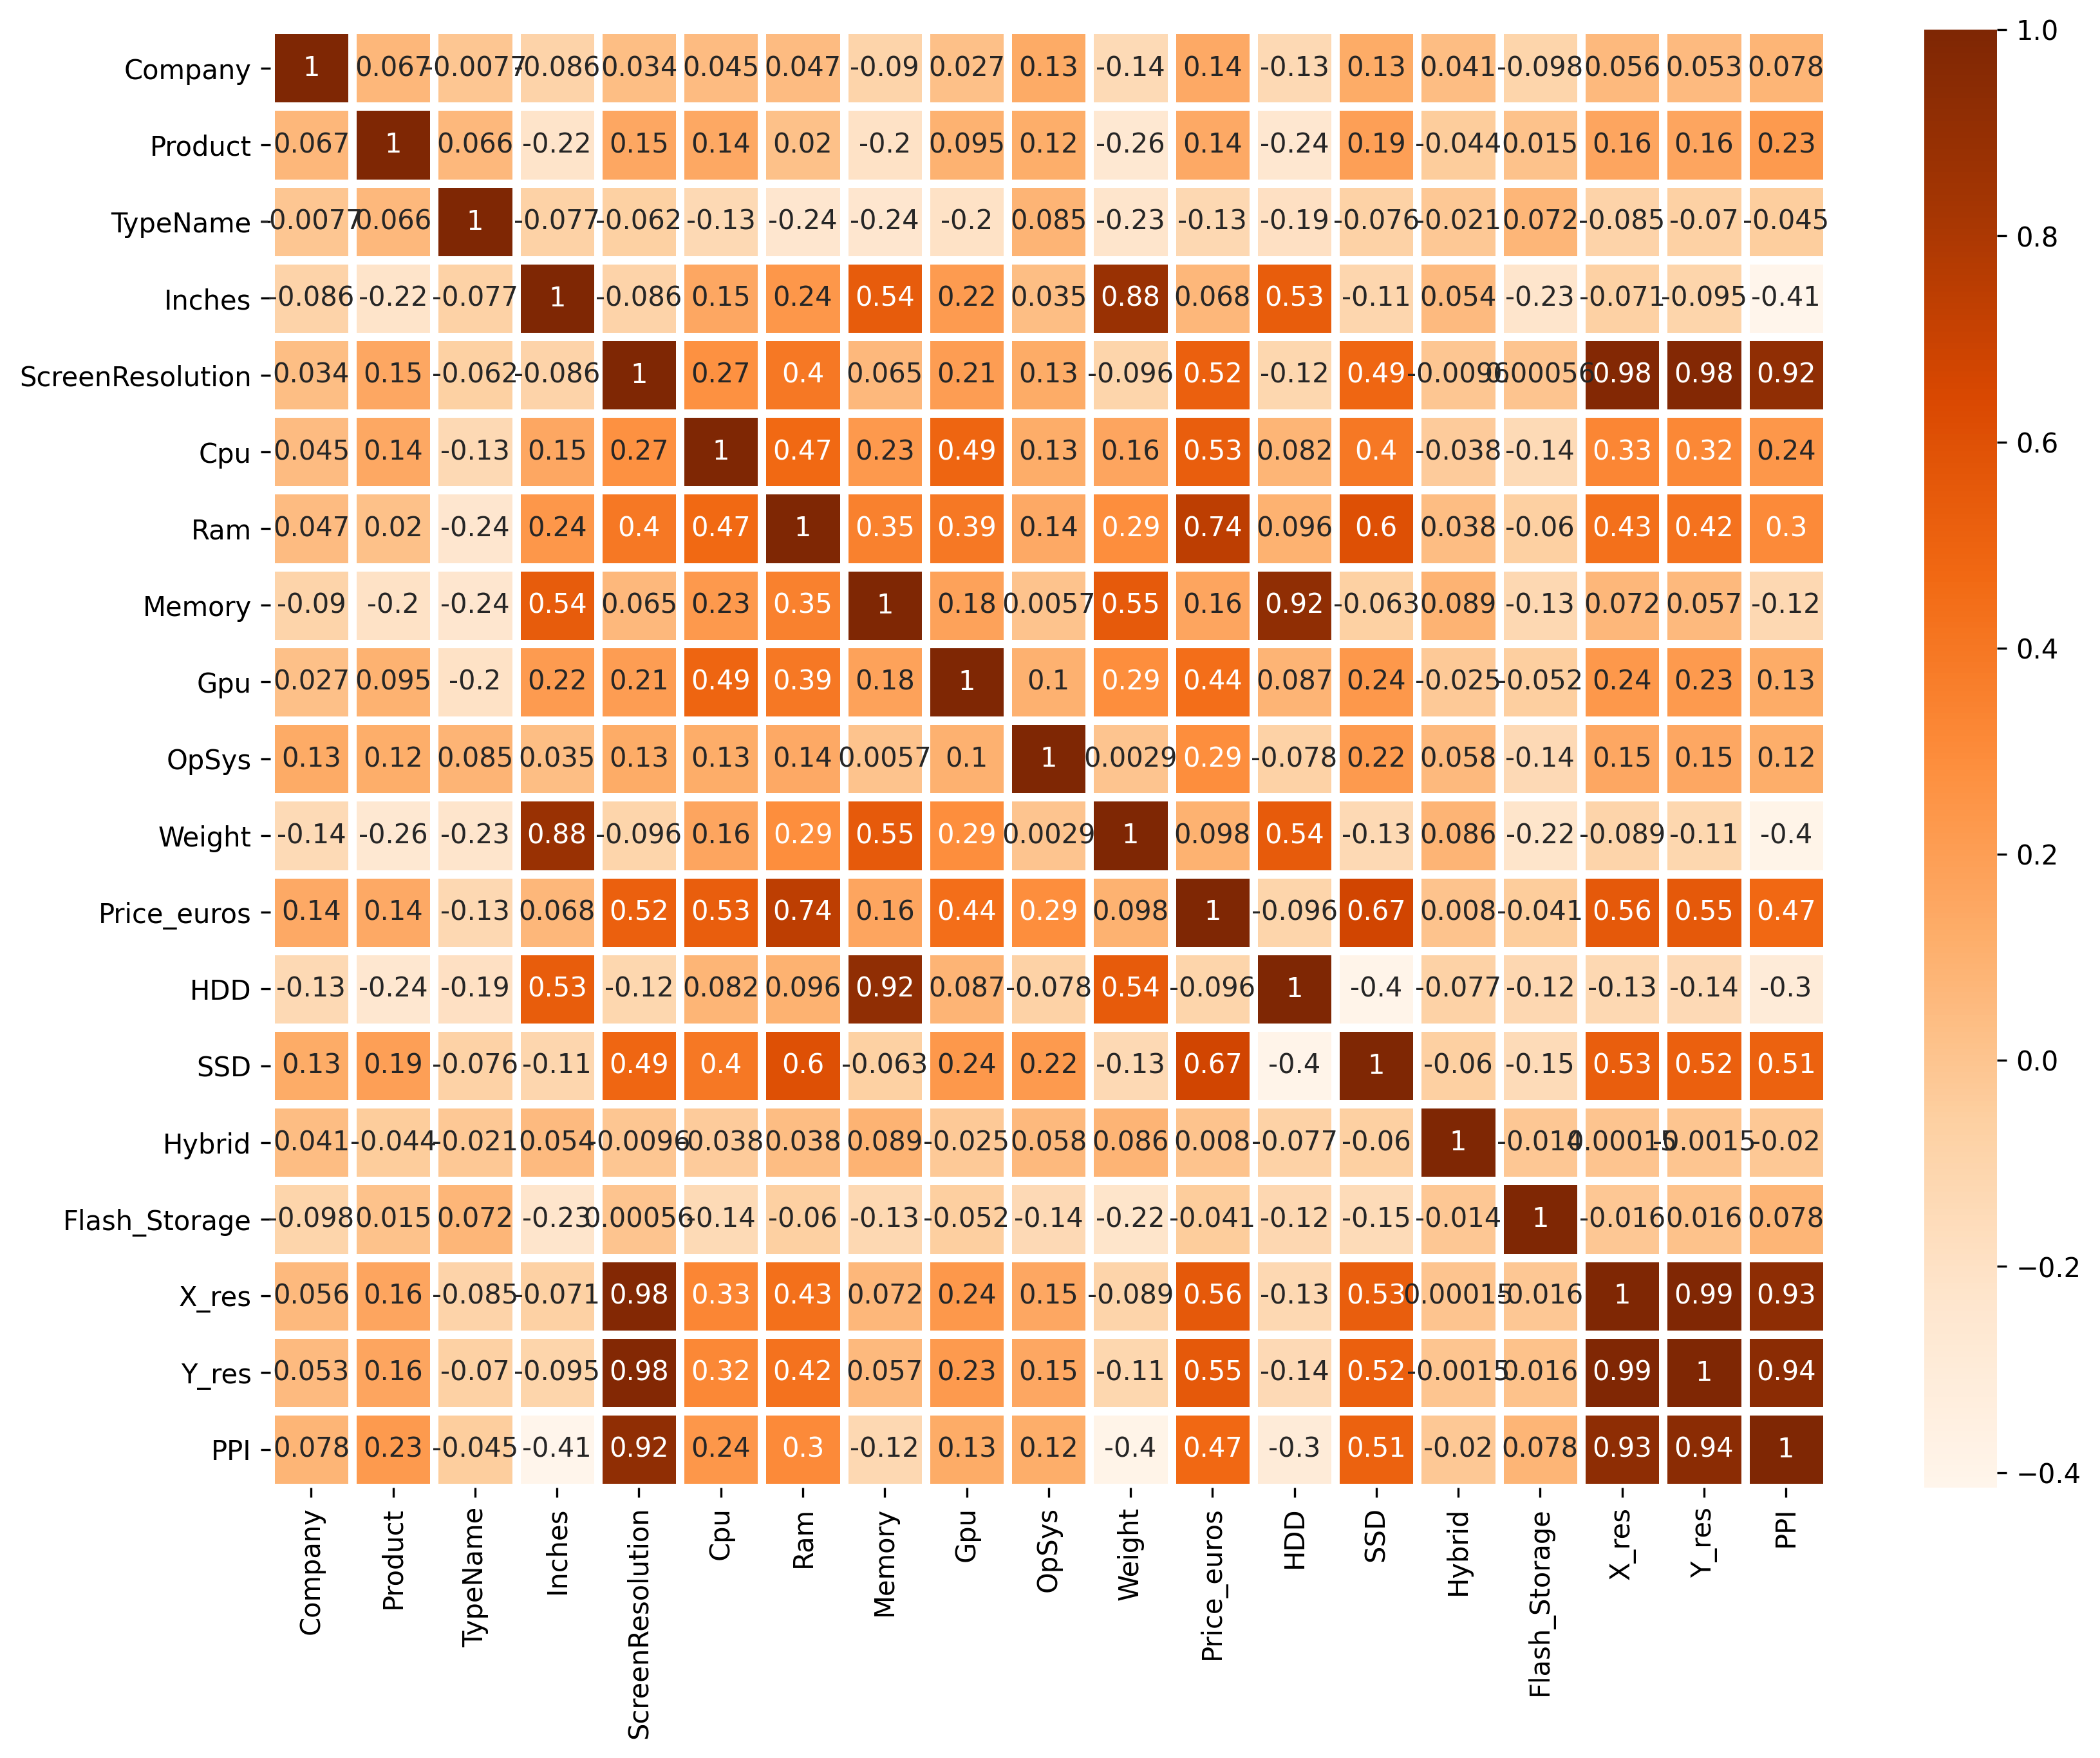

In [15]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), cmap="Oranges", annot=True, linewidths=3)

In [16]:
def to_df(scaled, col_list):
    d = pd.DataFrame(scaled, columns=col_list)
    return d

def kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))

    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)

    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

In [17]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price_euros', axis=1), data['Price_euros'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = to_df(X_train, data.drop('Price_euros', axis=1).columns)
X_test_df = to_df(X_test, data.drop('Price_euros', axis=1).columns)

X_train_df.shape, X_test_df.shape

((1042, 18), (261, 18))

## Масштабирование признаков

In [18]:
scale_cols = ["Weight"]

### 1 способ (Z-оценки)

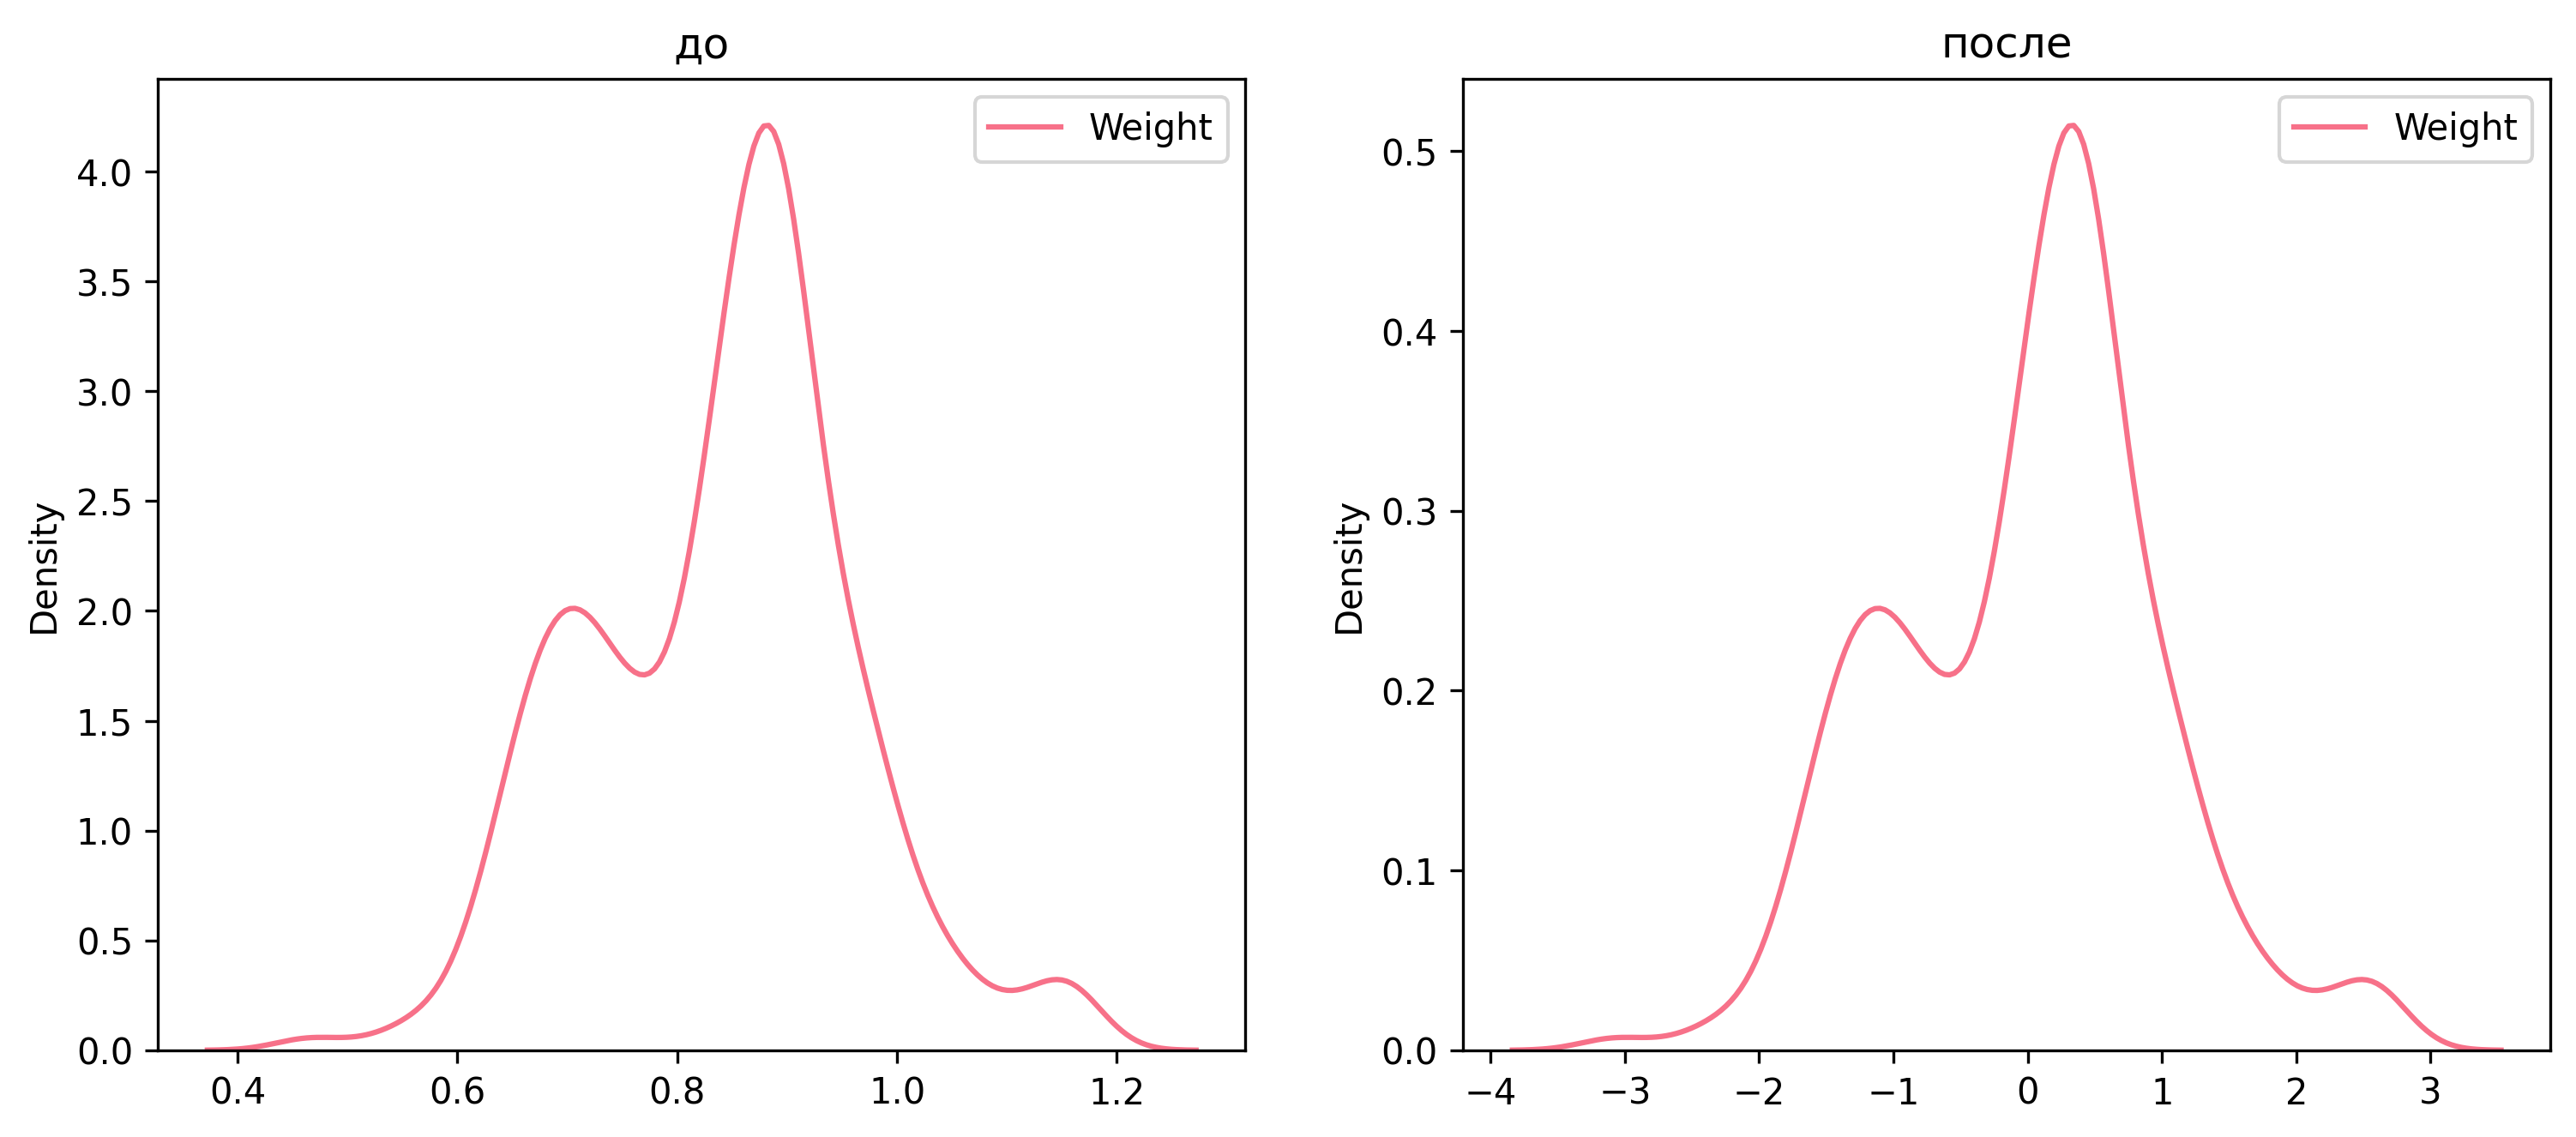

In [19]:
# Обучаем StandardScaler на всей выборке и масштабируем
weight_standard_scaler = StandardScaler().fit_transform(X_train[scale_cols])
# формируем DataFrame на основе массива
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_train, weight_standard_scaler, 'до', 'после')

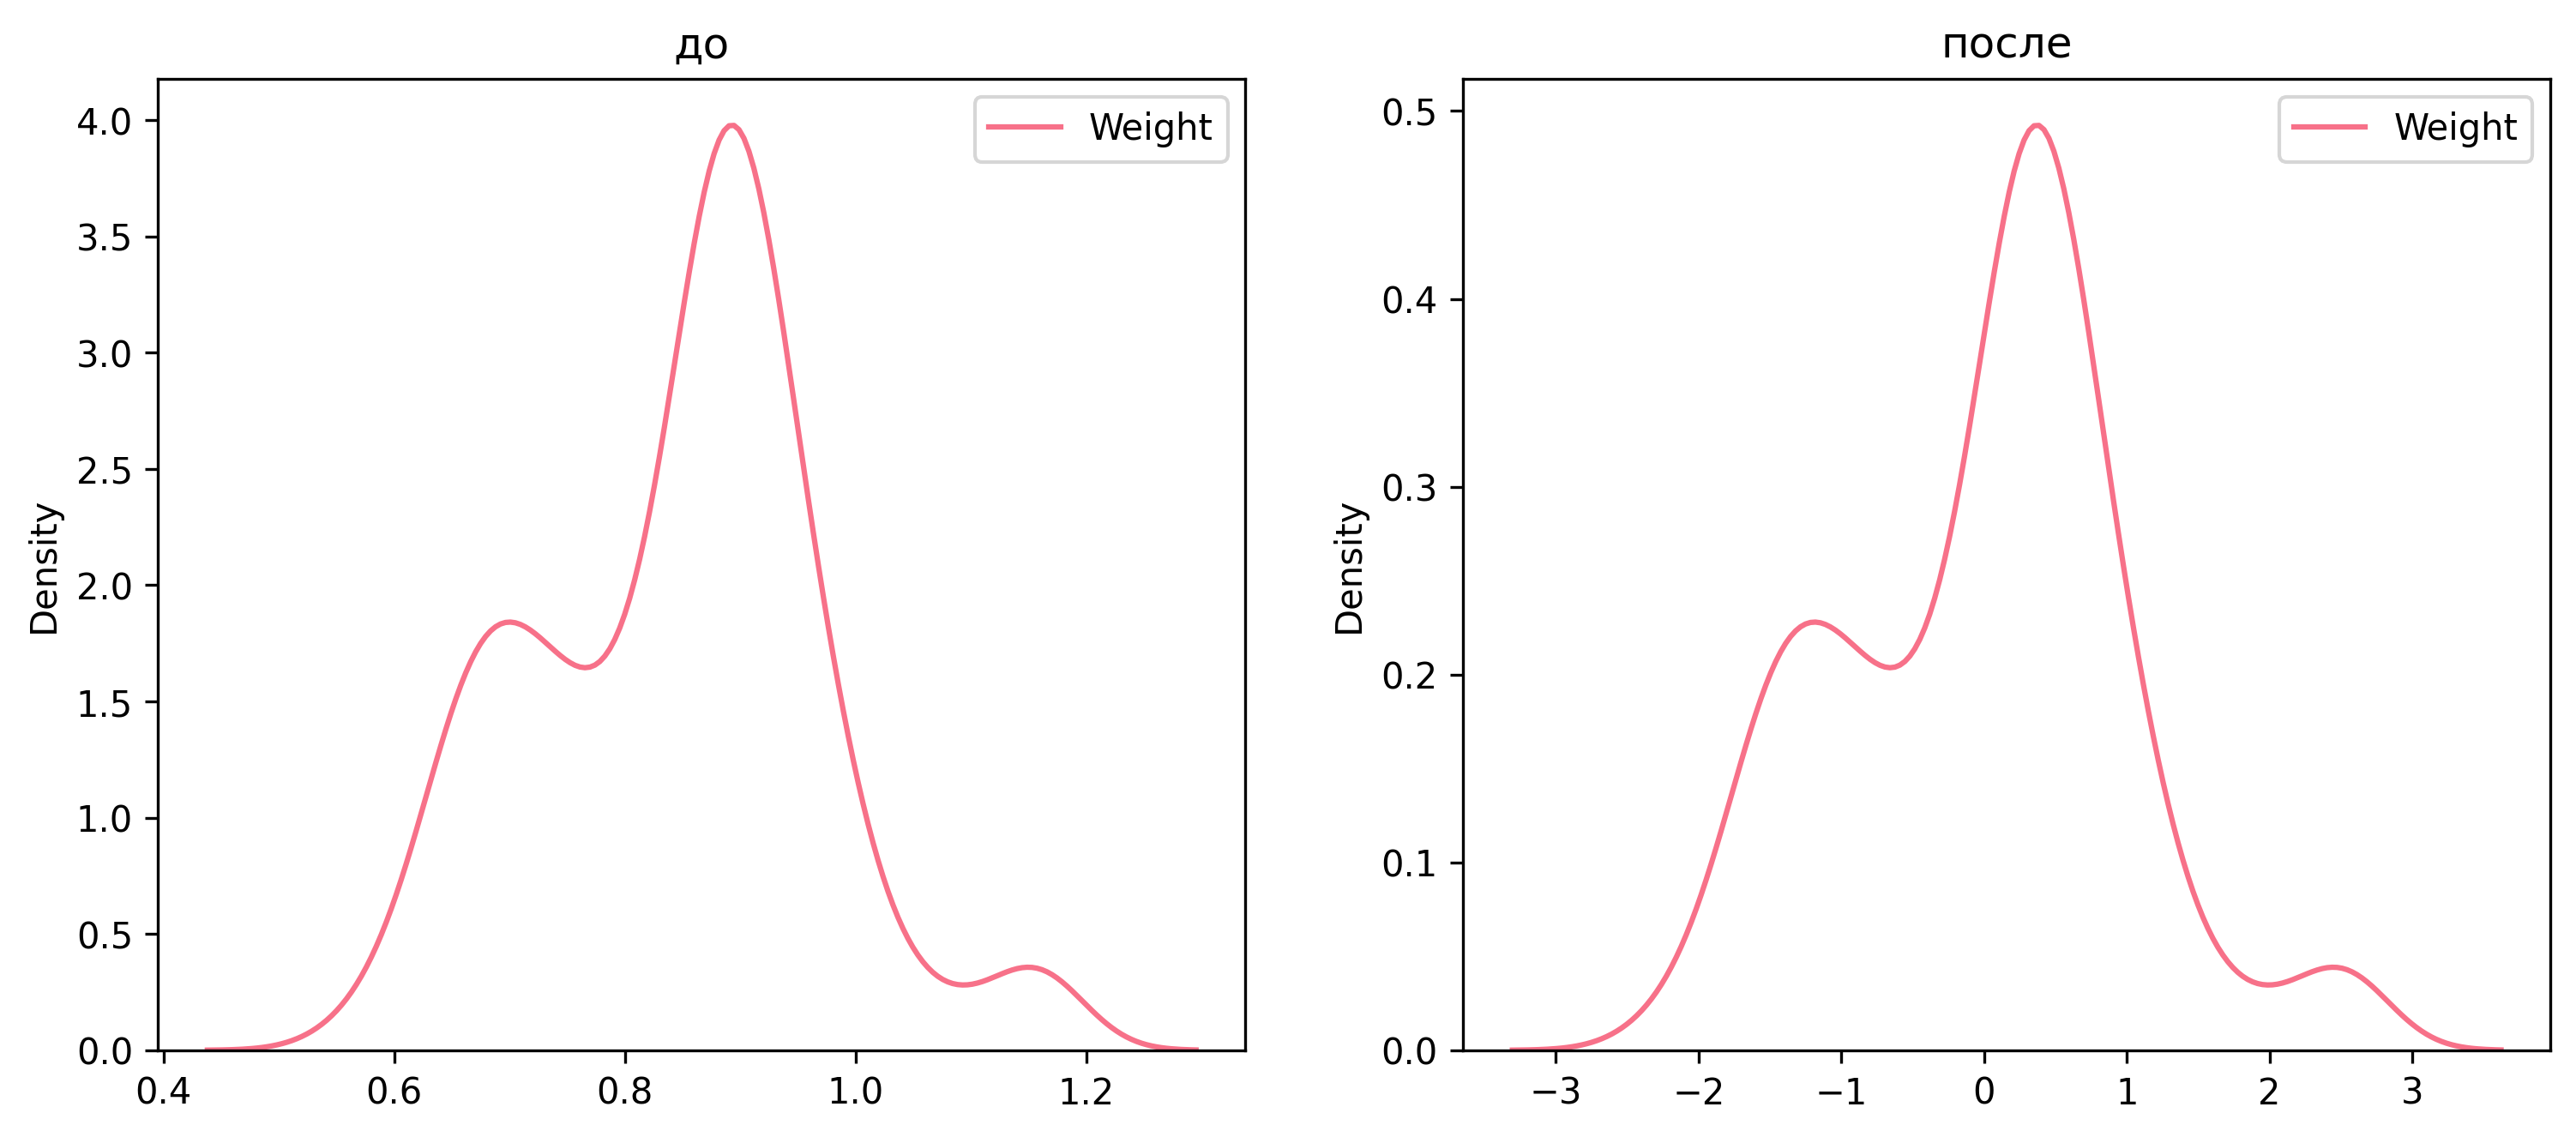

In [20]:
# Обучаем StandardScaler на всей выборке и масштабируем
weight_standard_scaler = StandardScaler().fit_transform(X_test[scale_cols])
# формируем DataFrame на основе массива
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_test, weight_standard_scaler, 'до', 'после')

### 2 способ (Mean Normalisation)

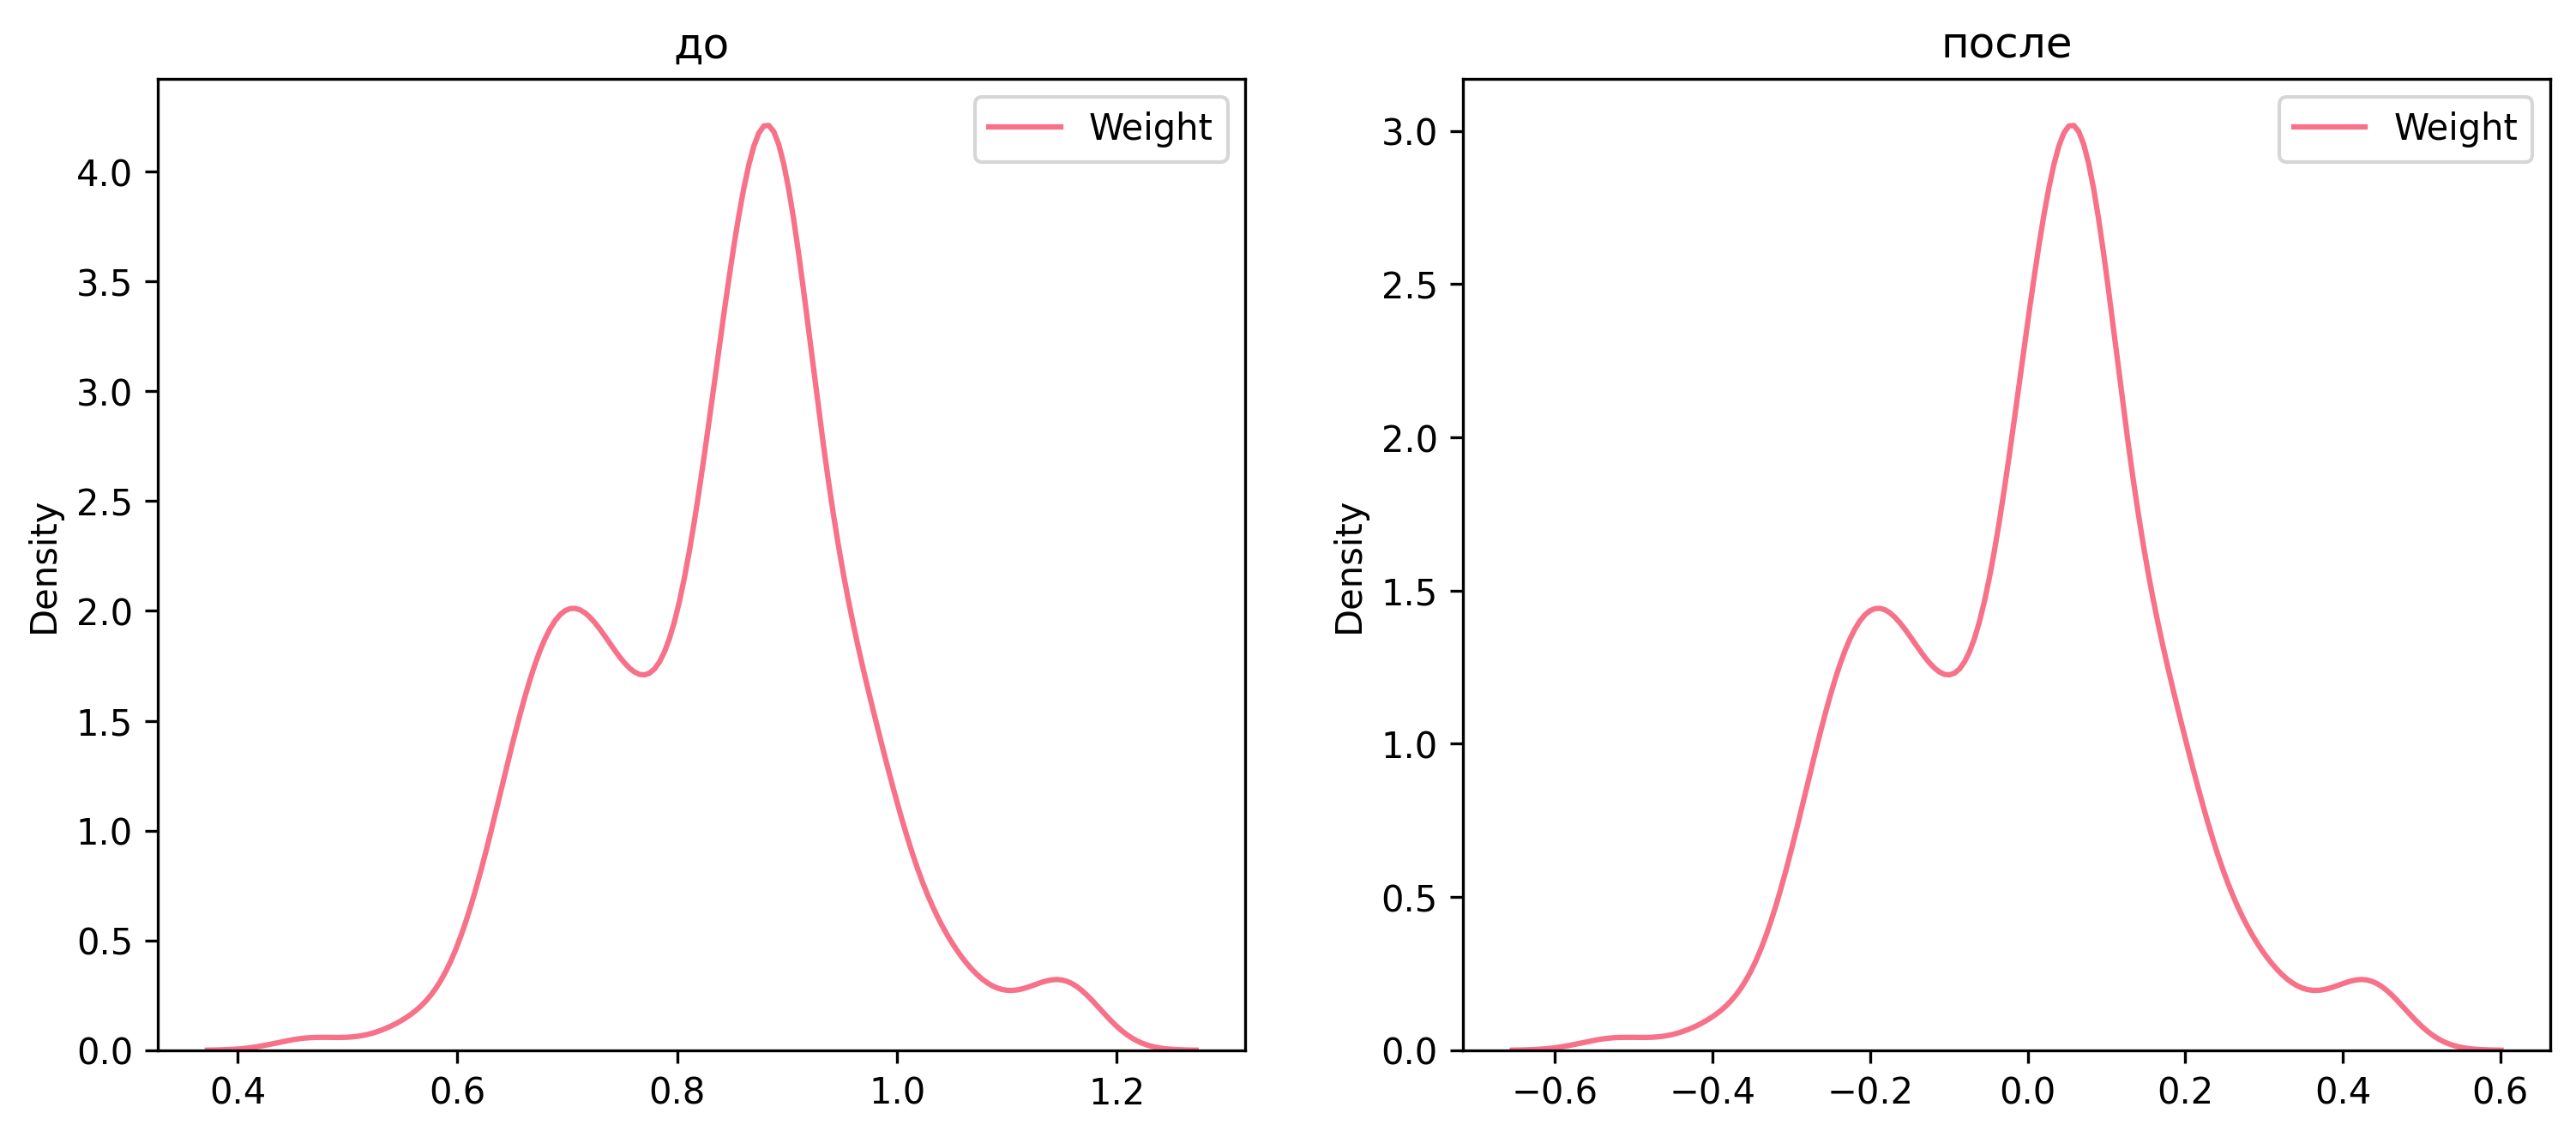

In [21]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = param_df.mean(axis=0)
        maxs = param_df.max(axis=0)
        mins = param_df.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

weight_standard_scaler = MeanNormalisation().fit_transform(X_train[scale_cols])
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_train, weight_standard_scaler, 'до', 'после')

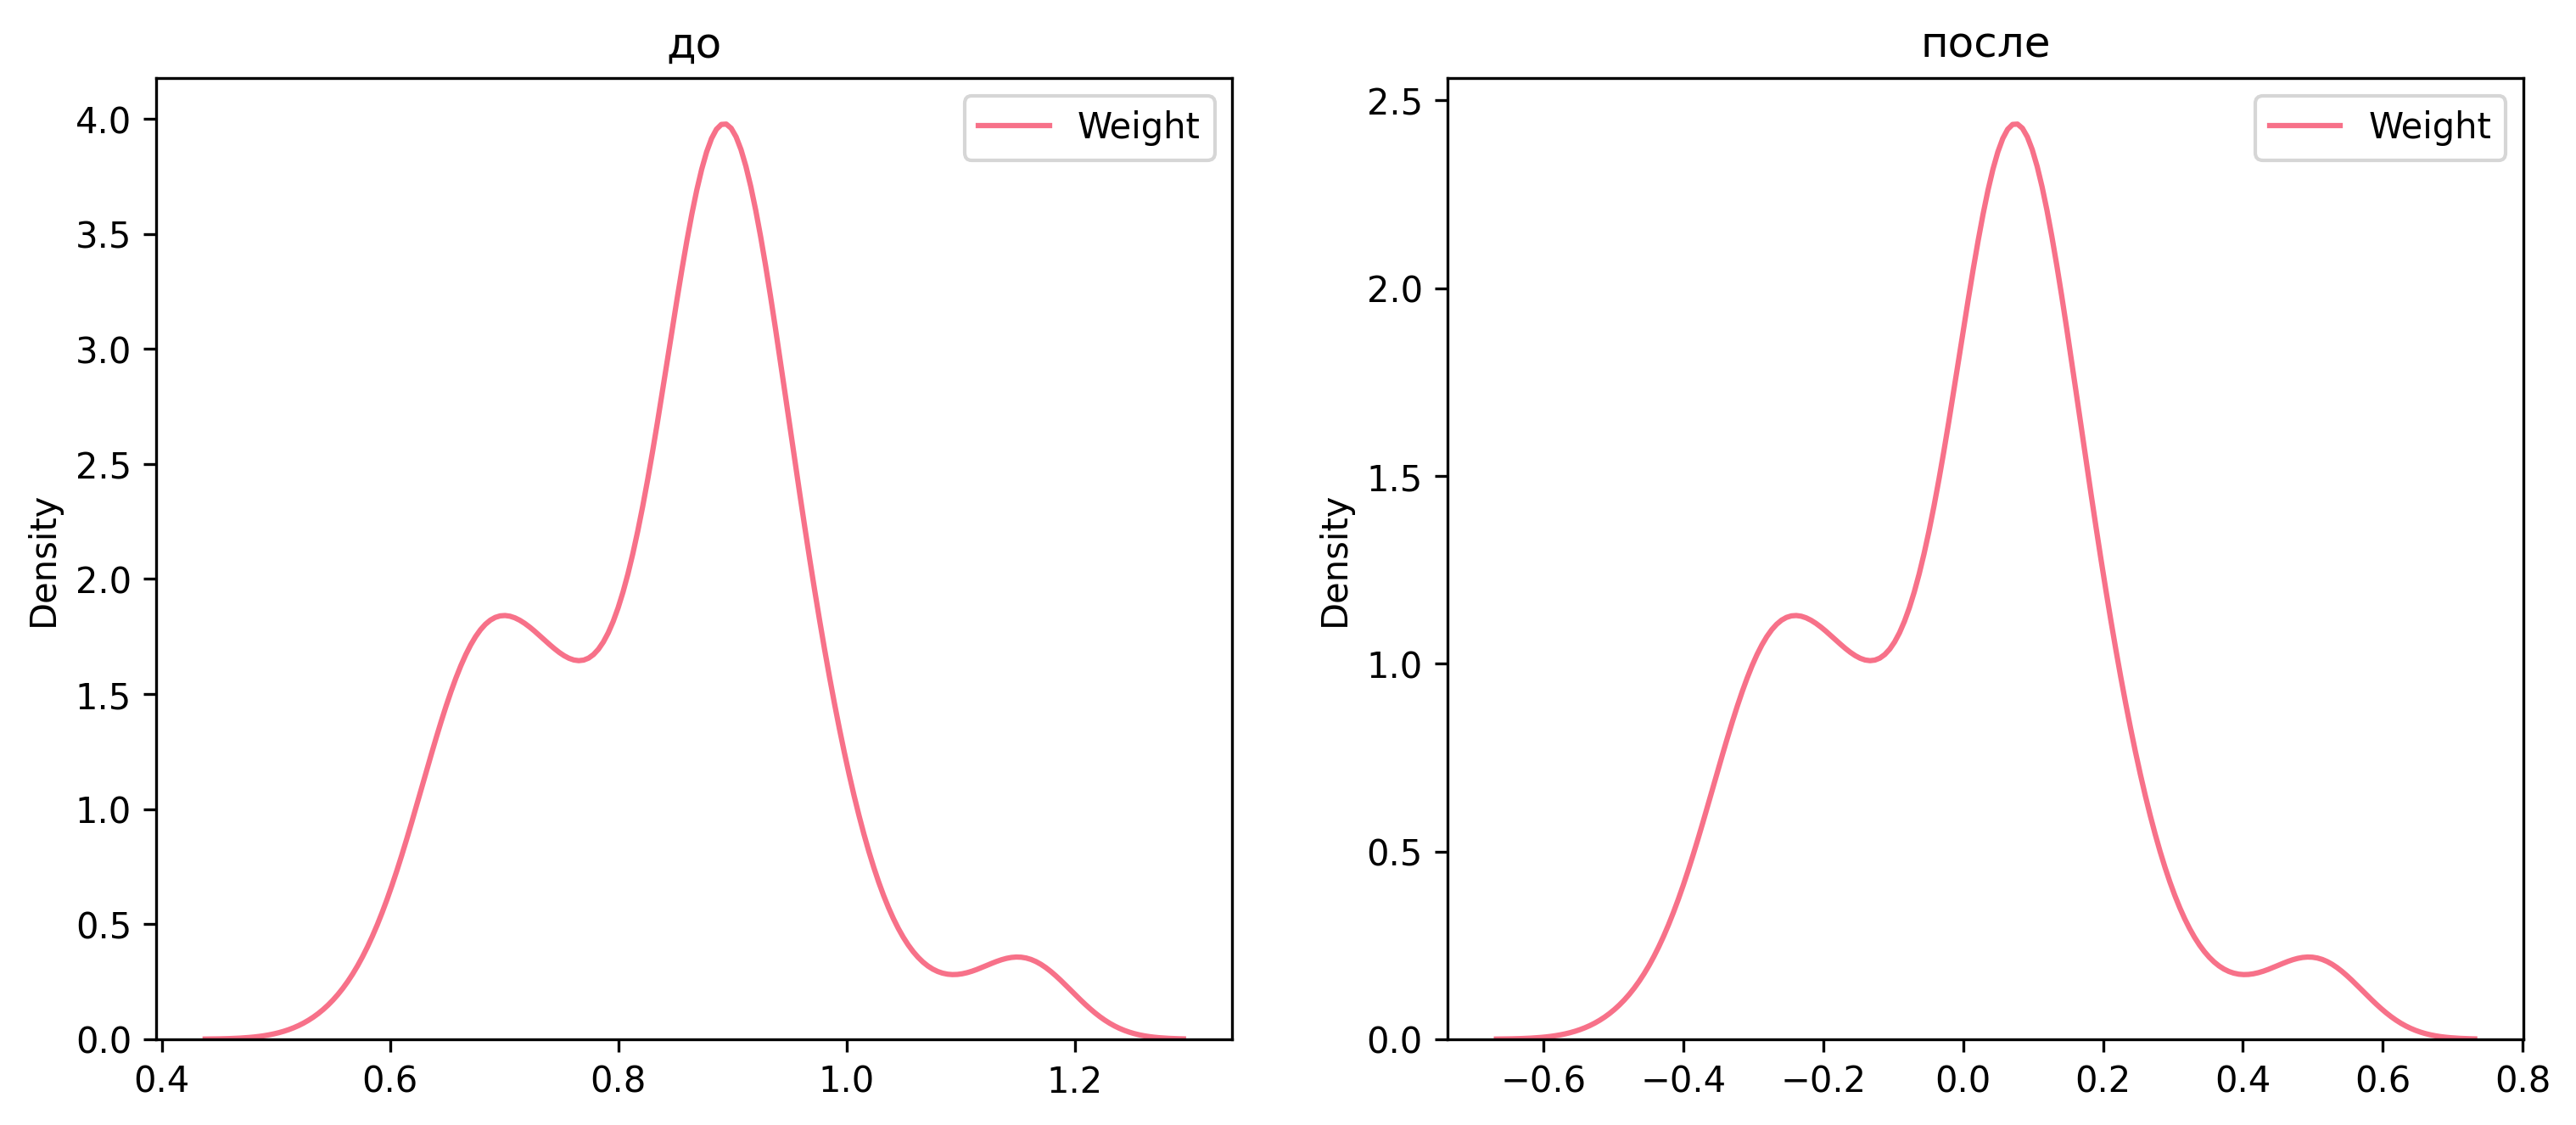

In [22]:
weight_standard_scaler = MeanNormalisation().fit_transform(X_test[scale_cols])
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_test, weight_standard_scaler, 'до', 'после')

### 3 способ (по медиане)

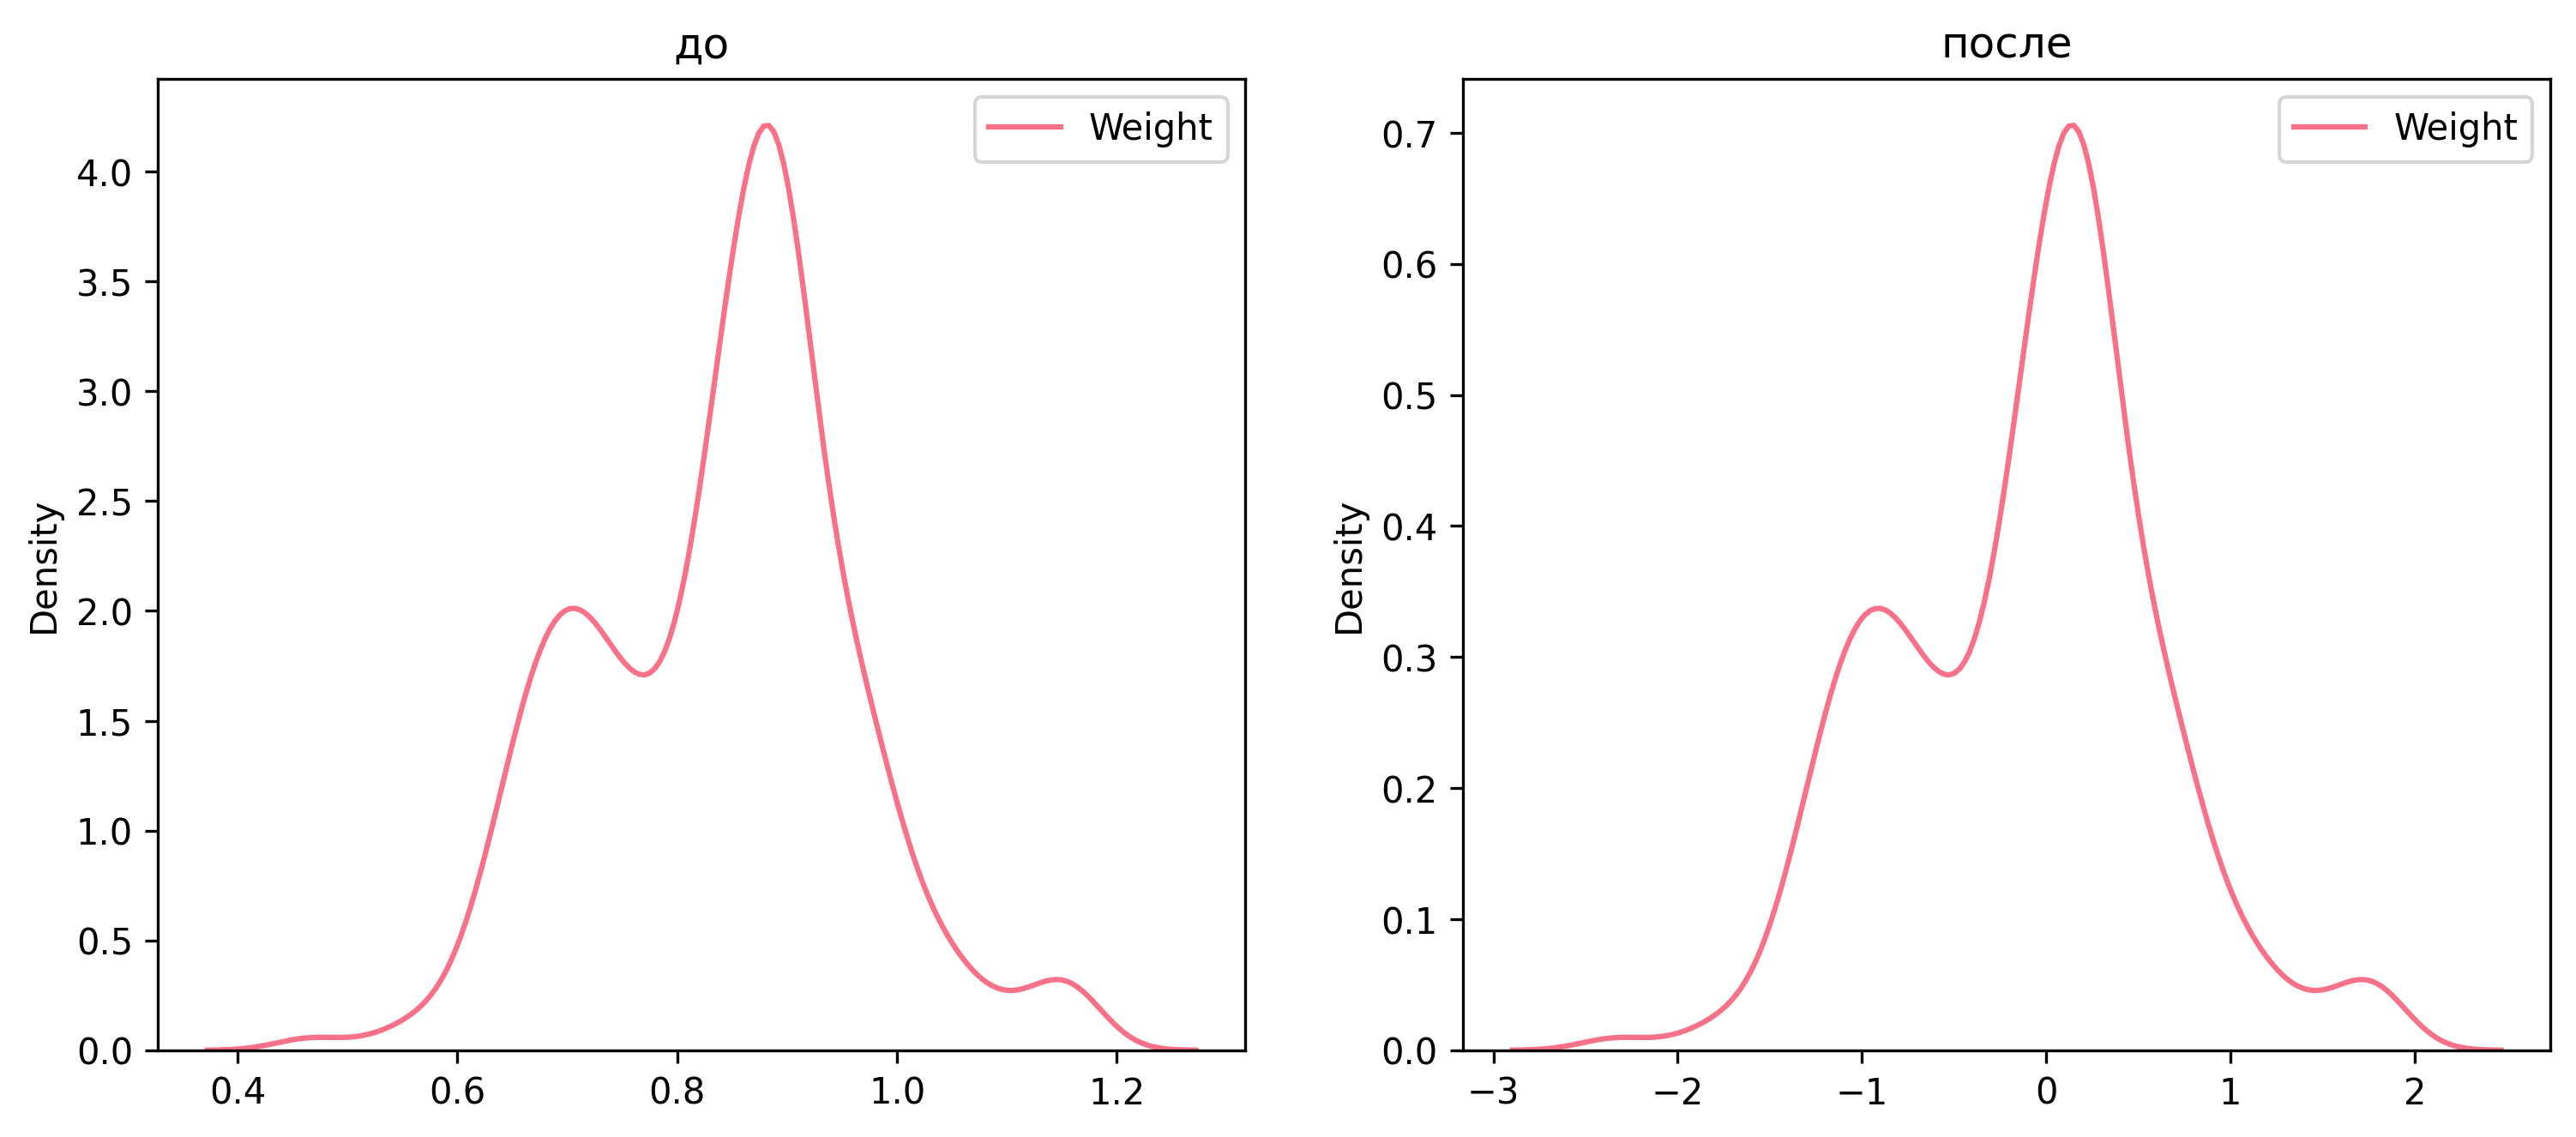

In [23]:
weight_standard_scaler = RobustScaler().fit_transform(X_train[scale_cols])
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_train, weight_standard_scaler, 'до', 'после')

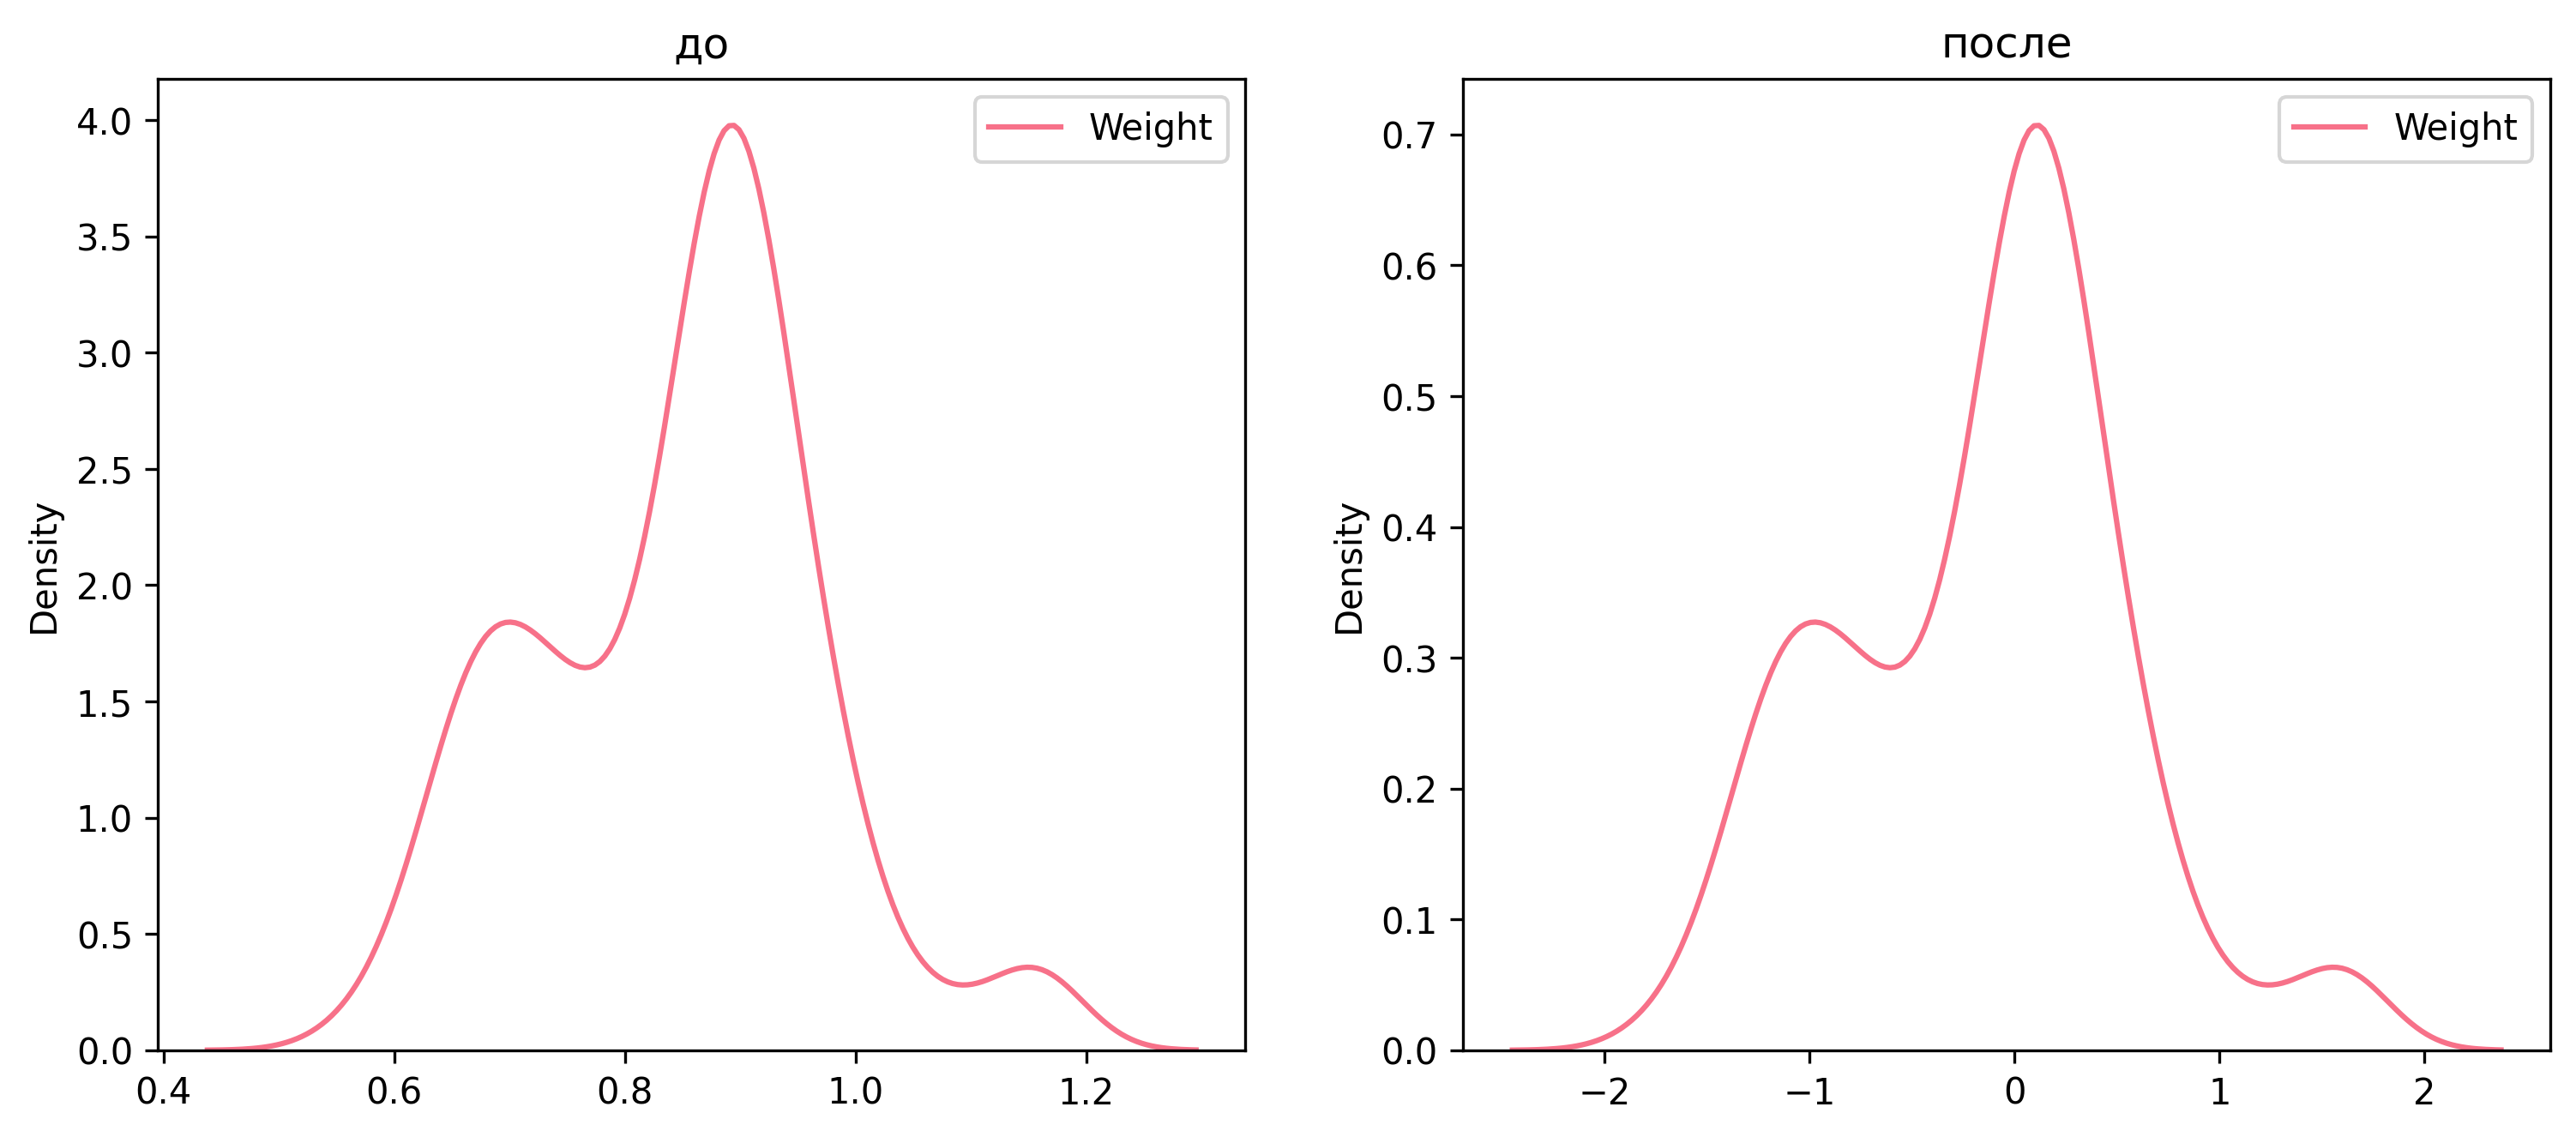

In [24]:
weight_standard_scaler = RobustScaler().fit_transform(X_test[scale_cols])
weight_standard_scaler =  to_df(weight_standard_scaler, scale_cols)
kde(scale_cols, X_test, weight_standard_scaler, 'до', 'после')

## Обработка выбросов для числовых признаков

### Удаление выбросов

In [25]:
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary 

def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

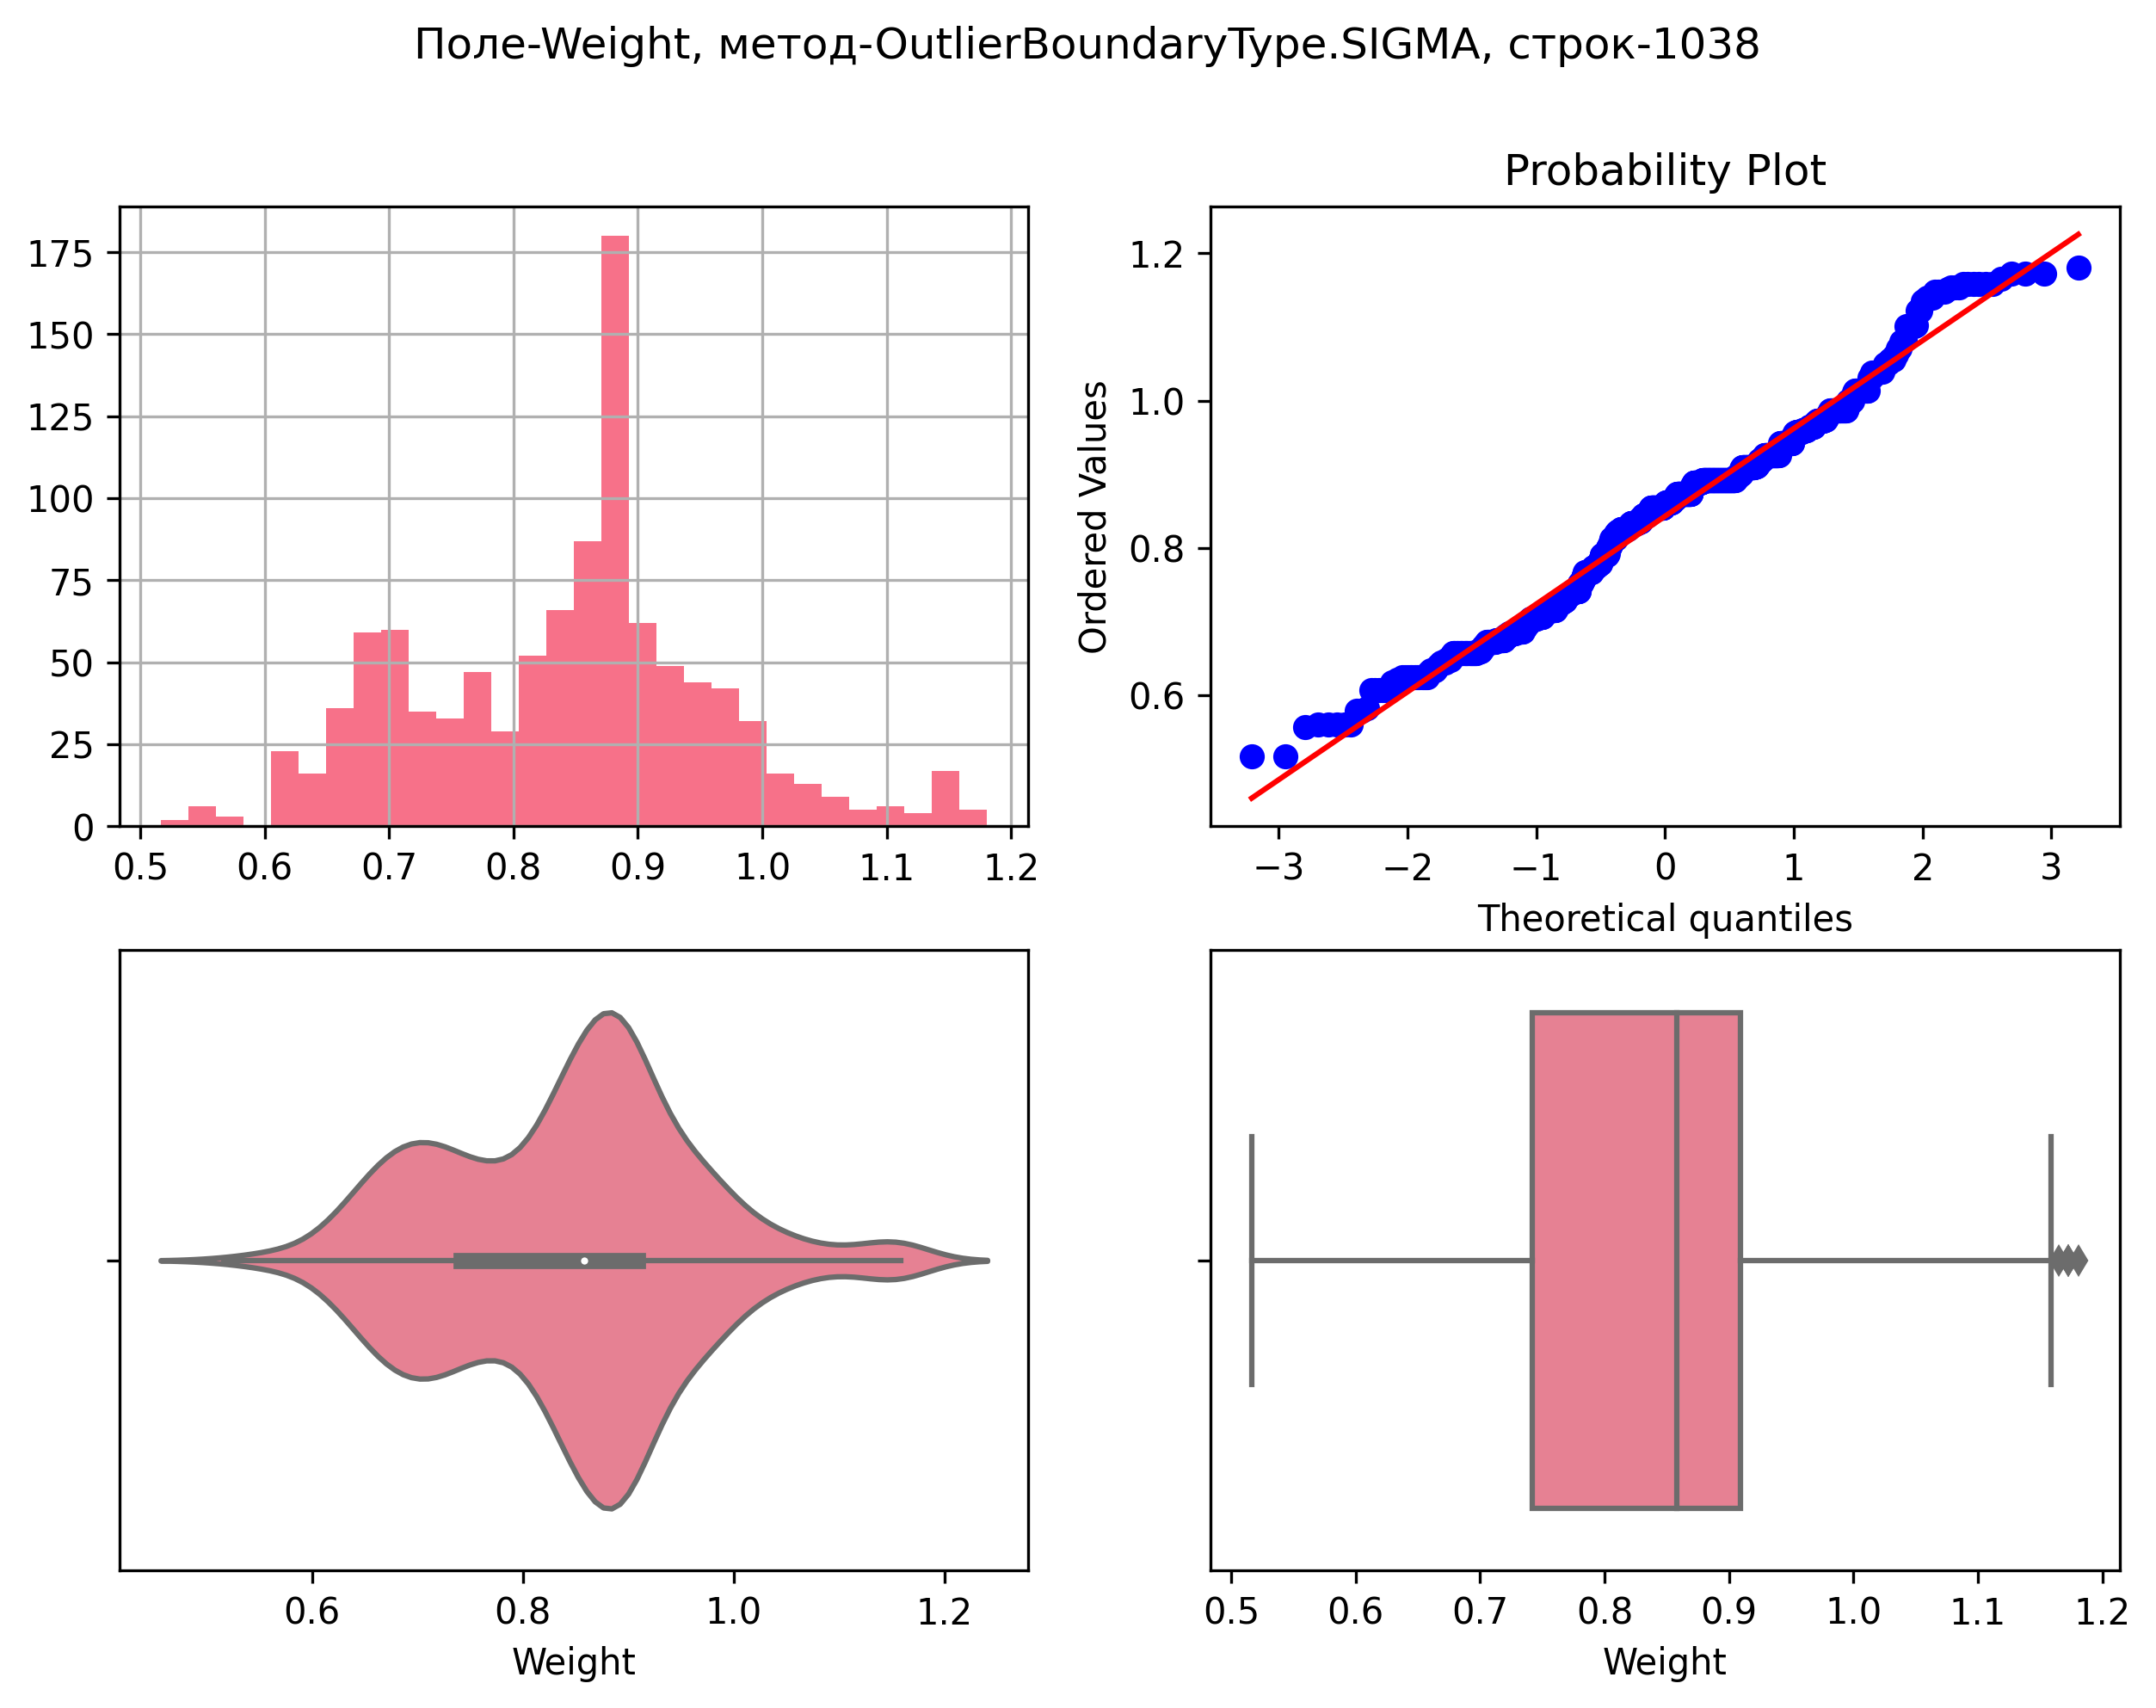

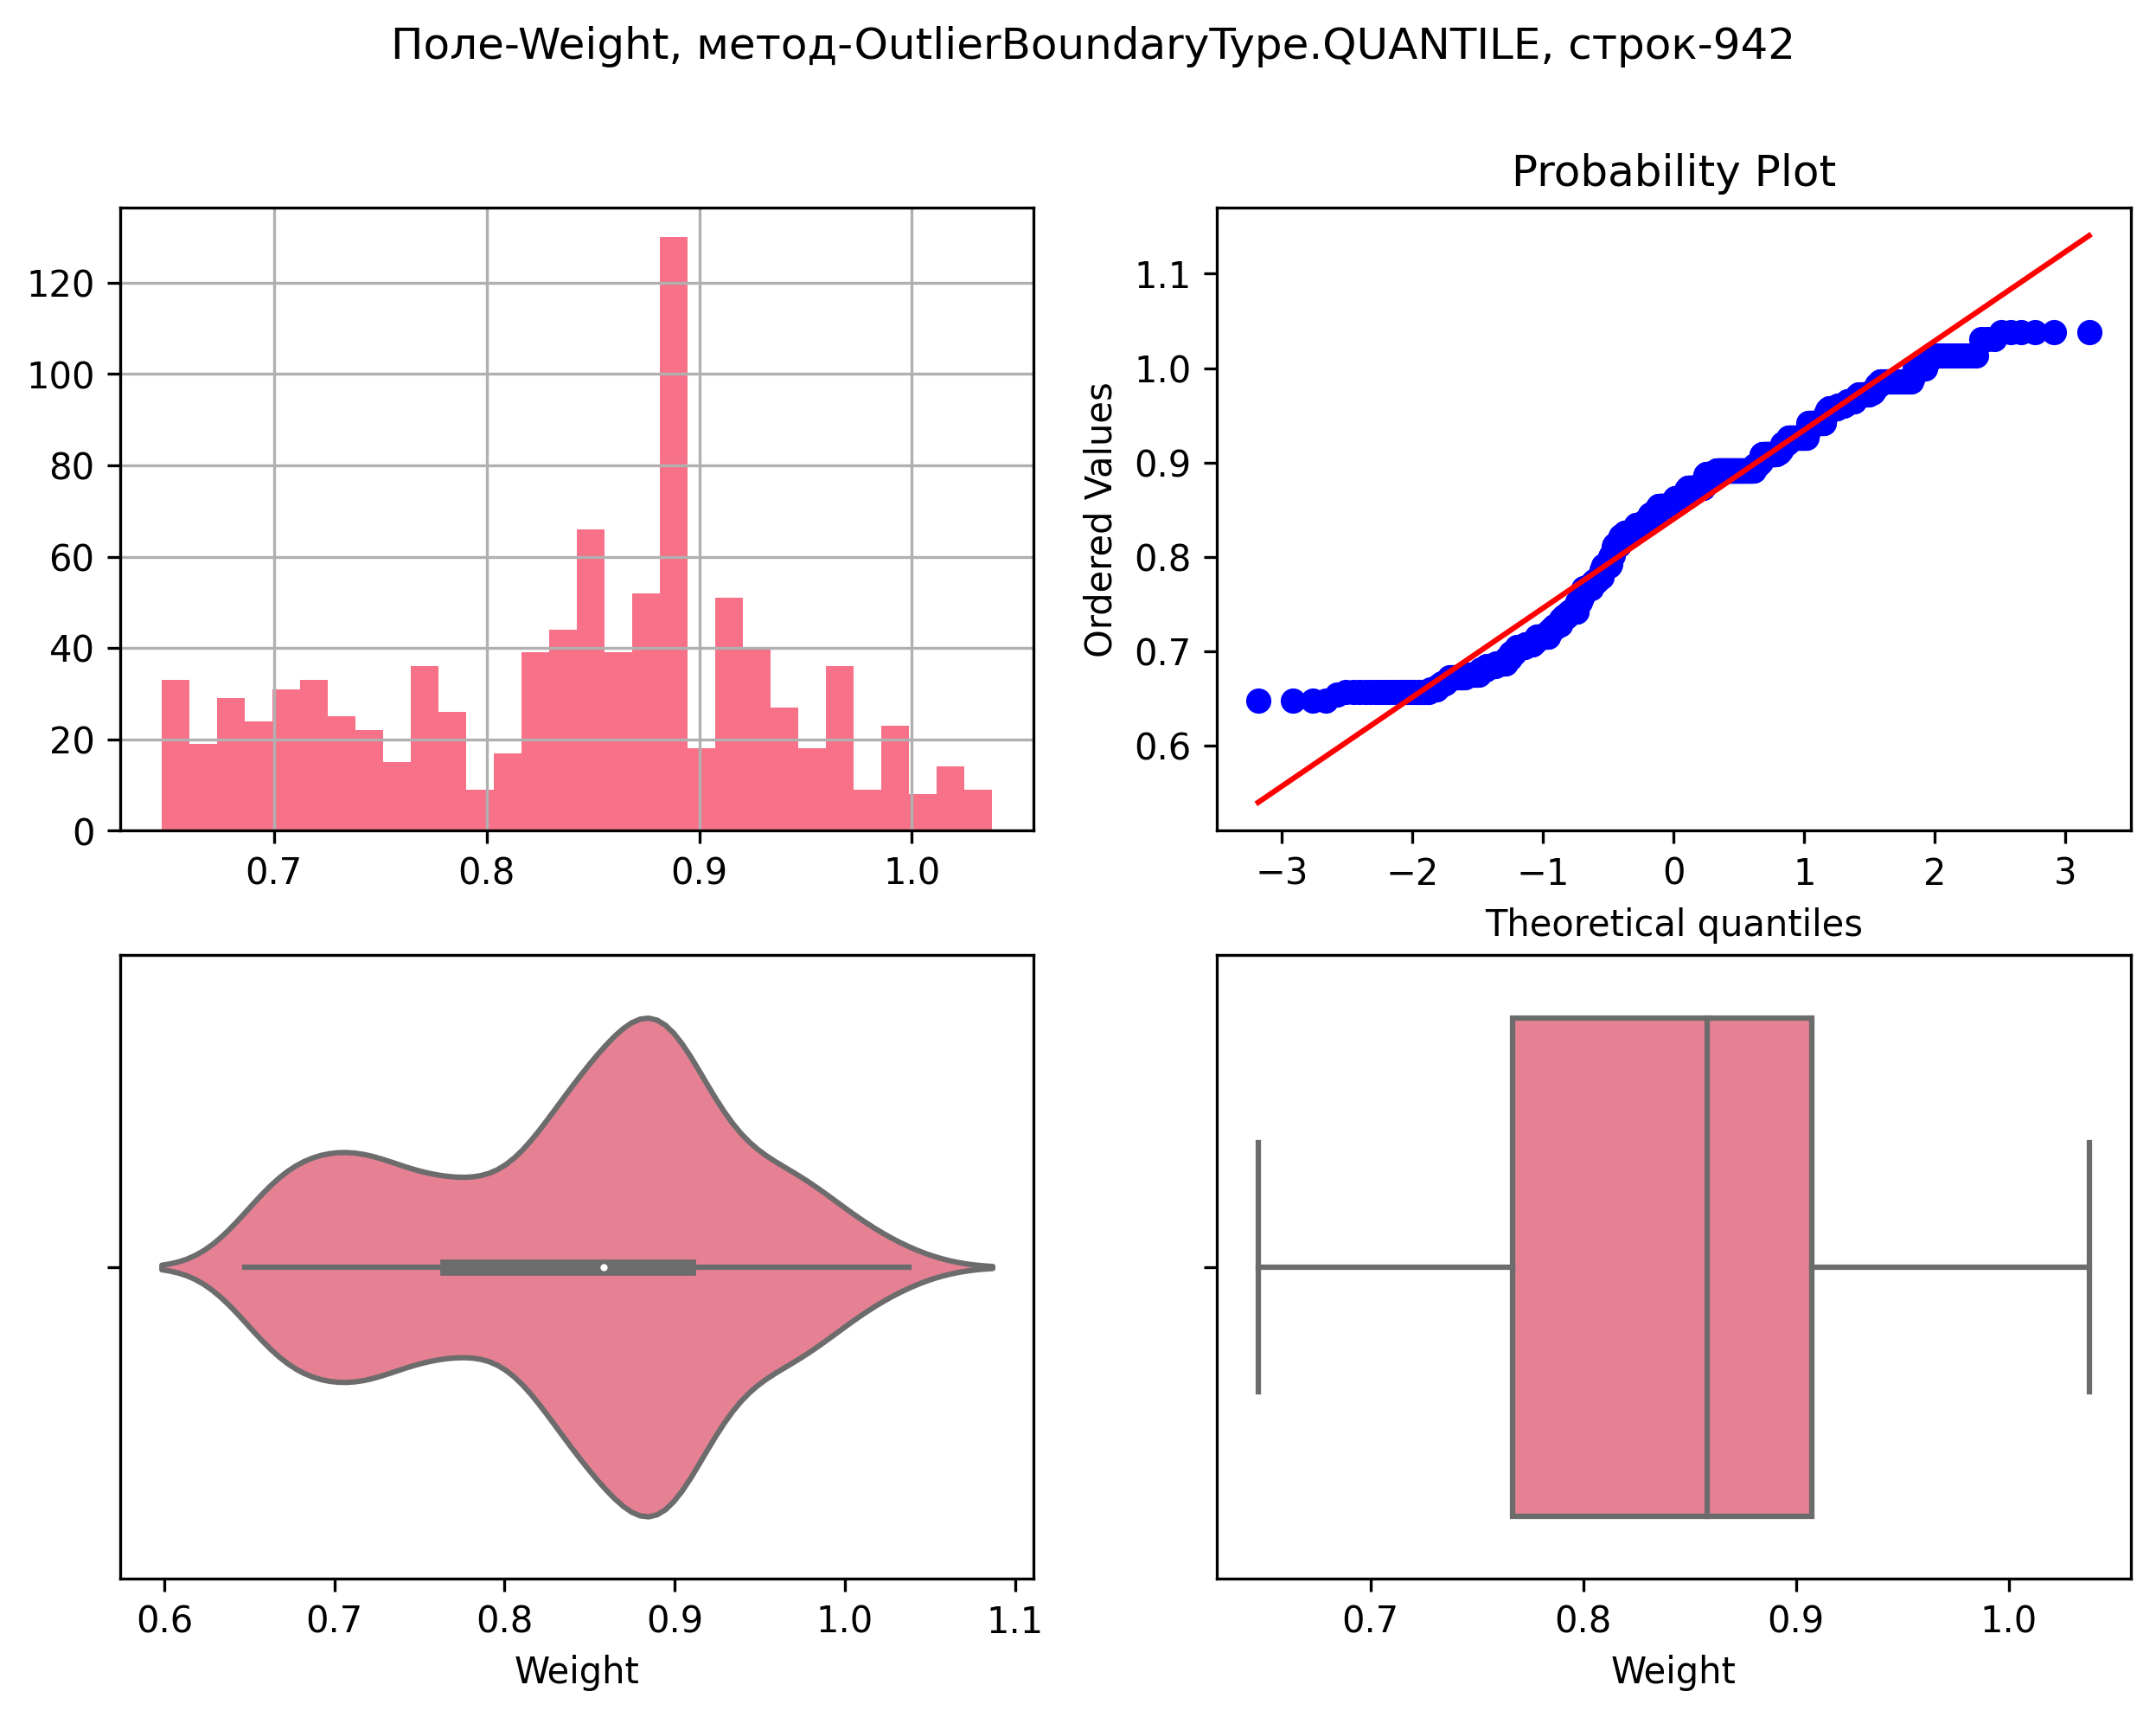

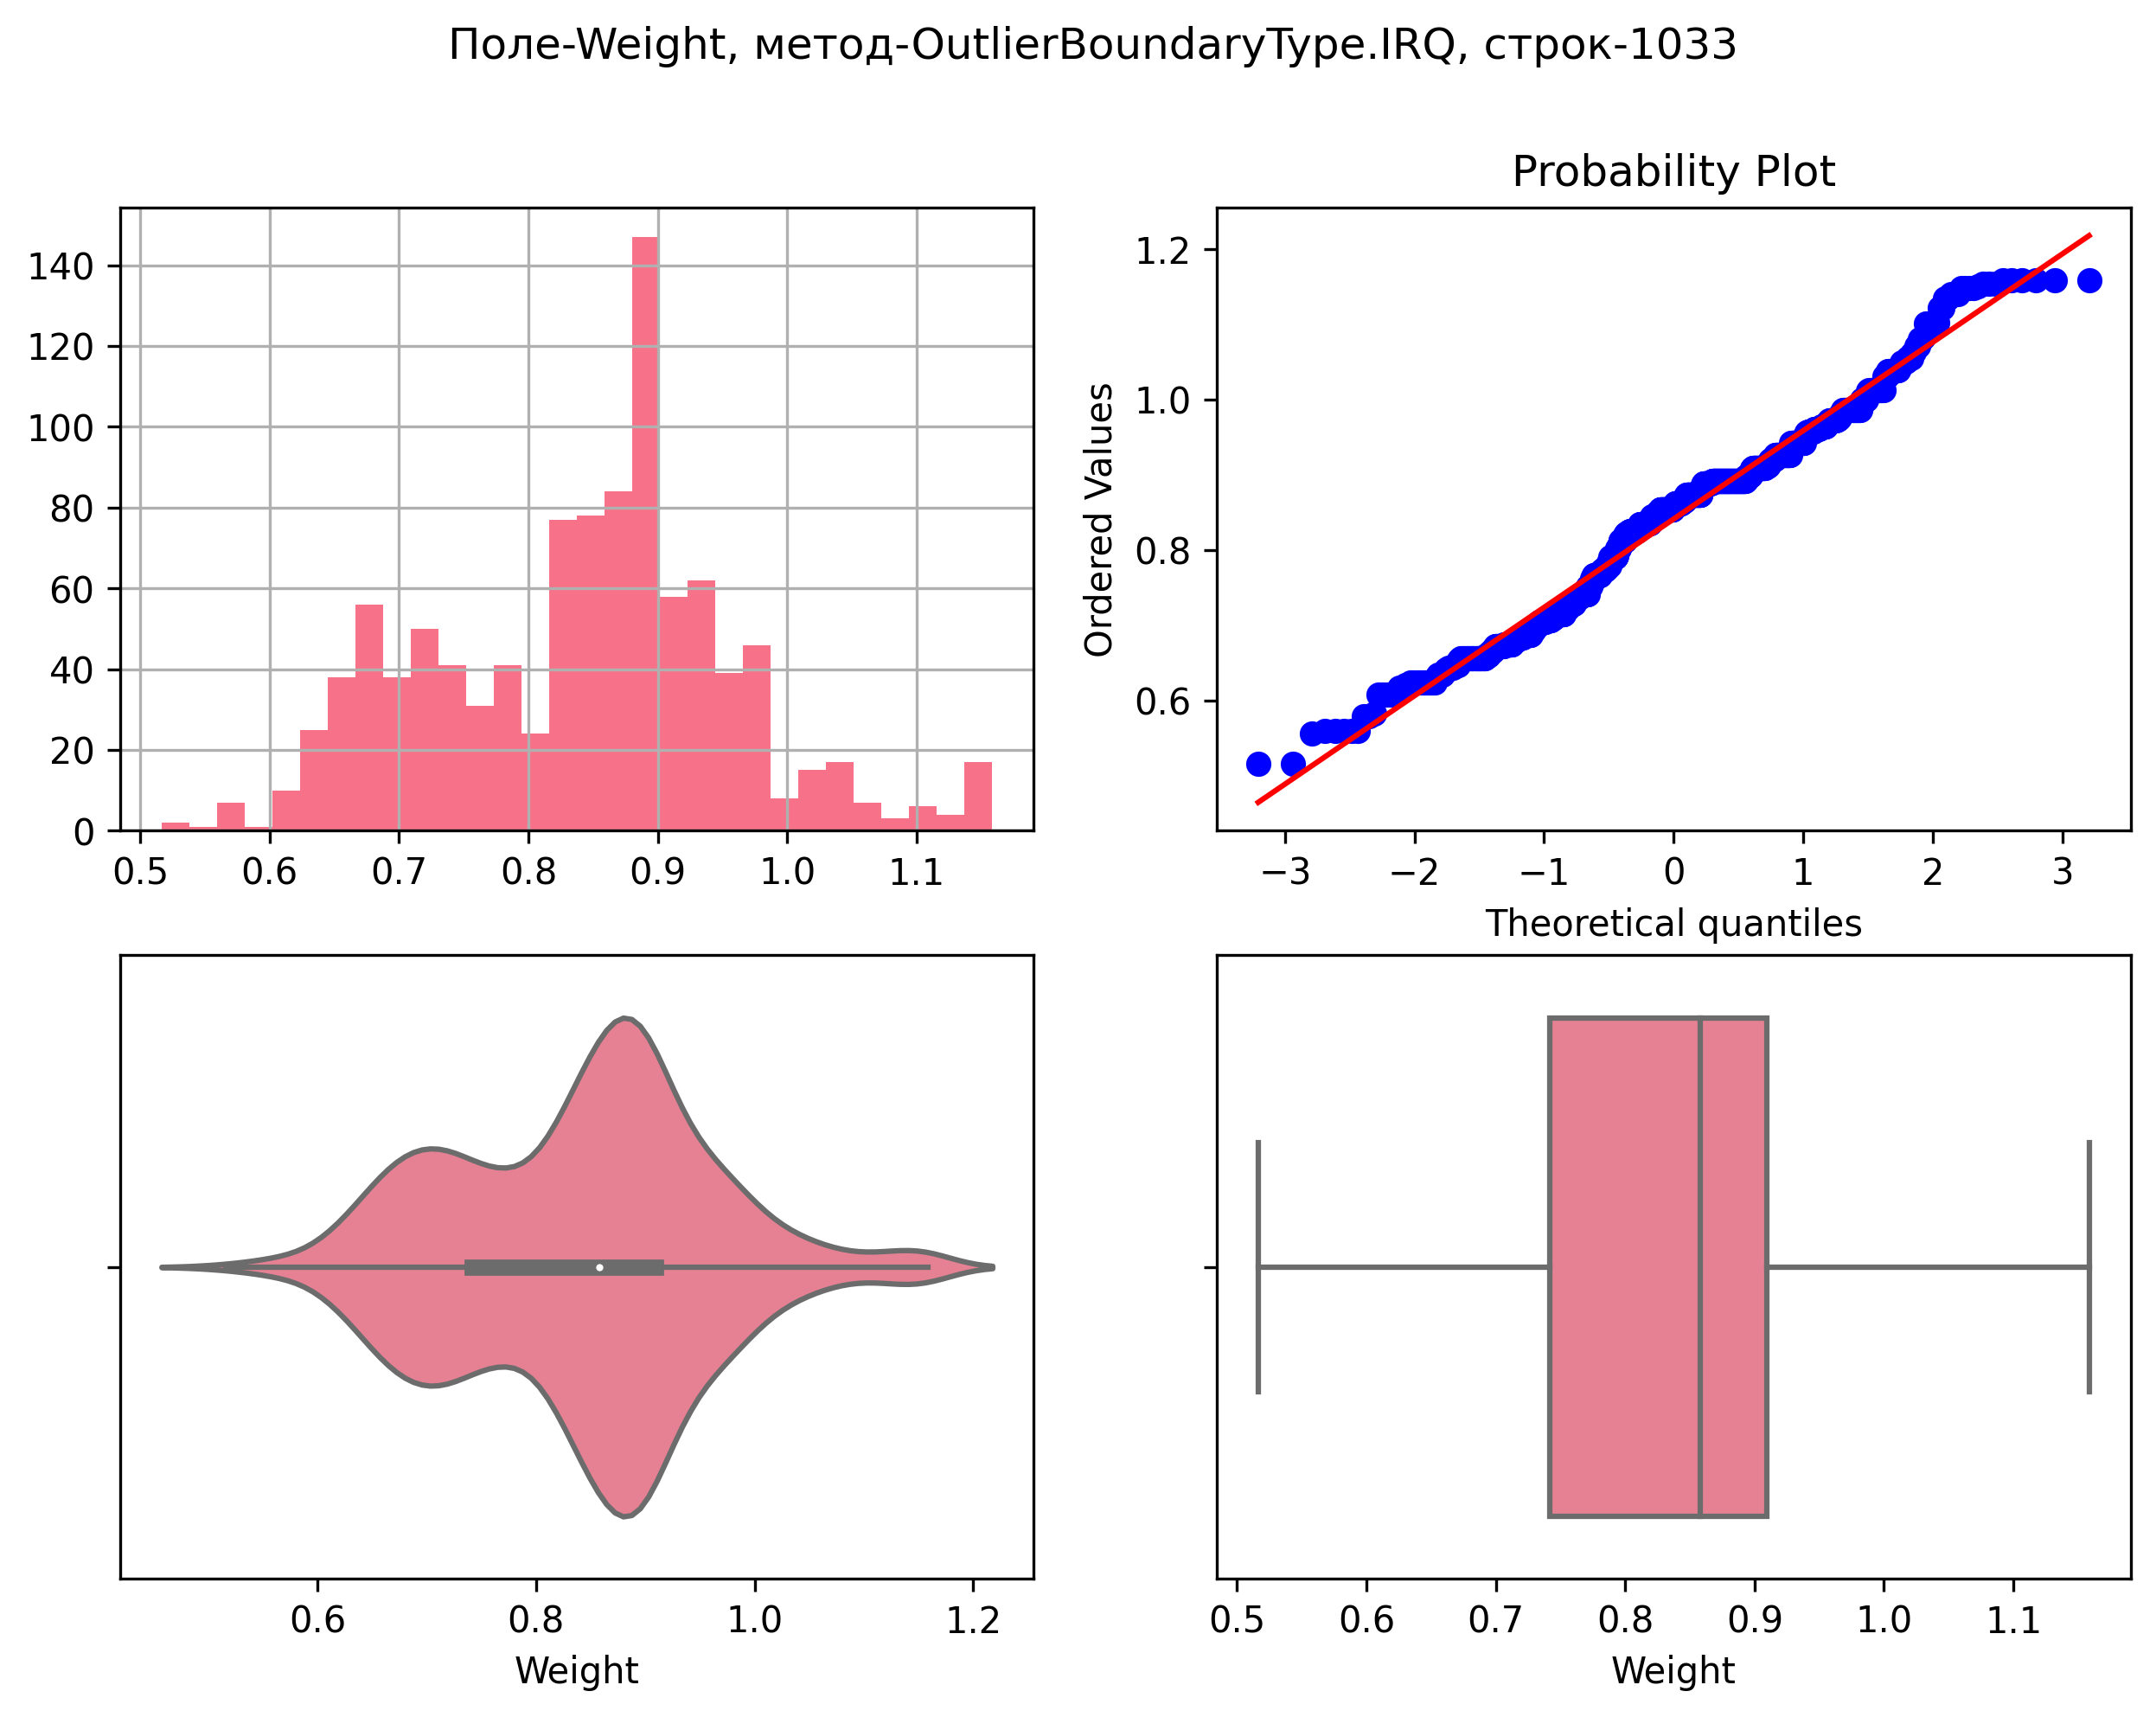

In [26]:
for col in scale_cols:
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(X_train, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(X_train[col] > upper_boundary, True, 
                                 np.where(X_train[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = X_train.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

### Замена выбросов

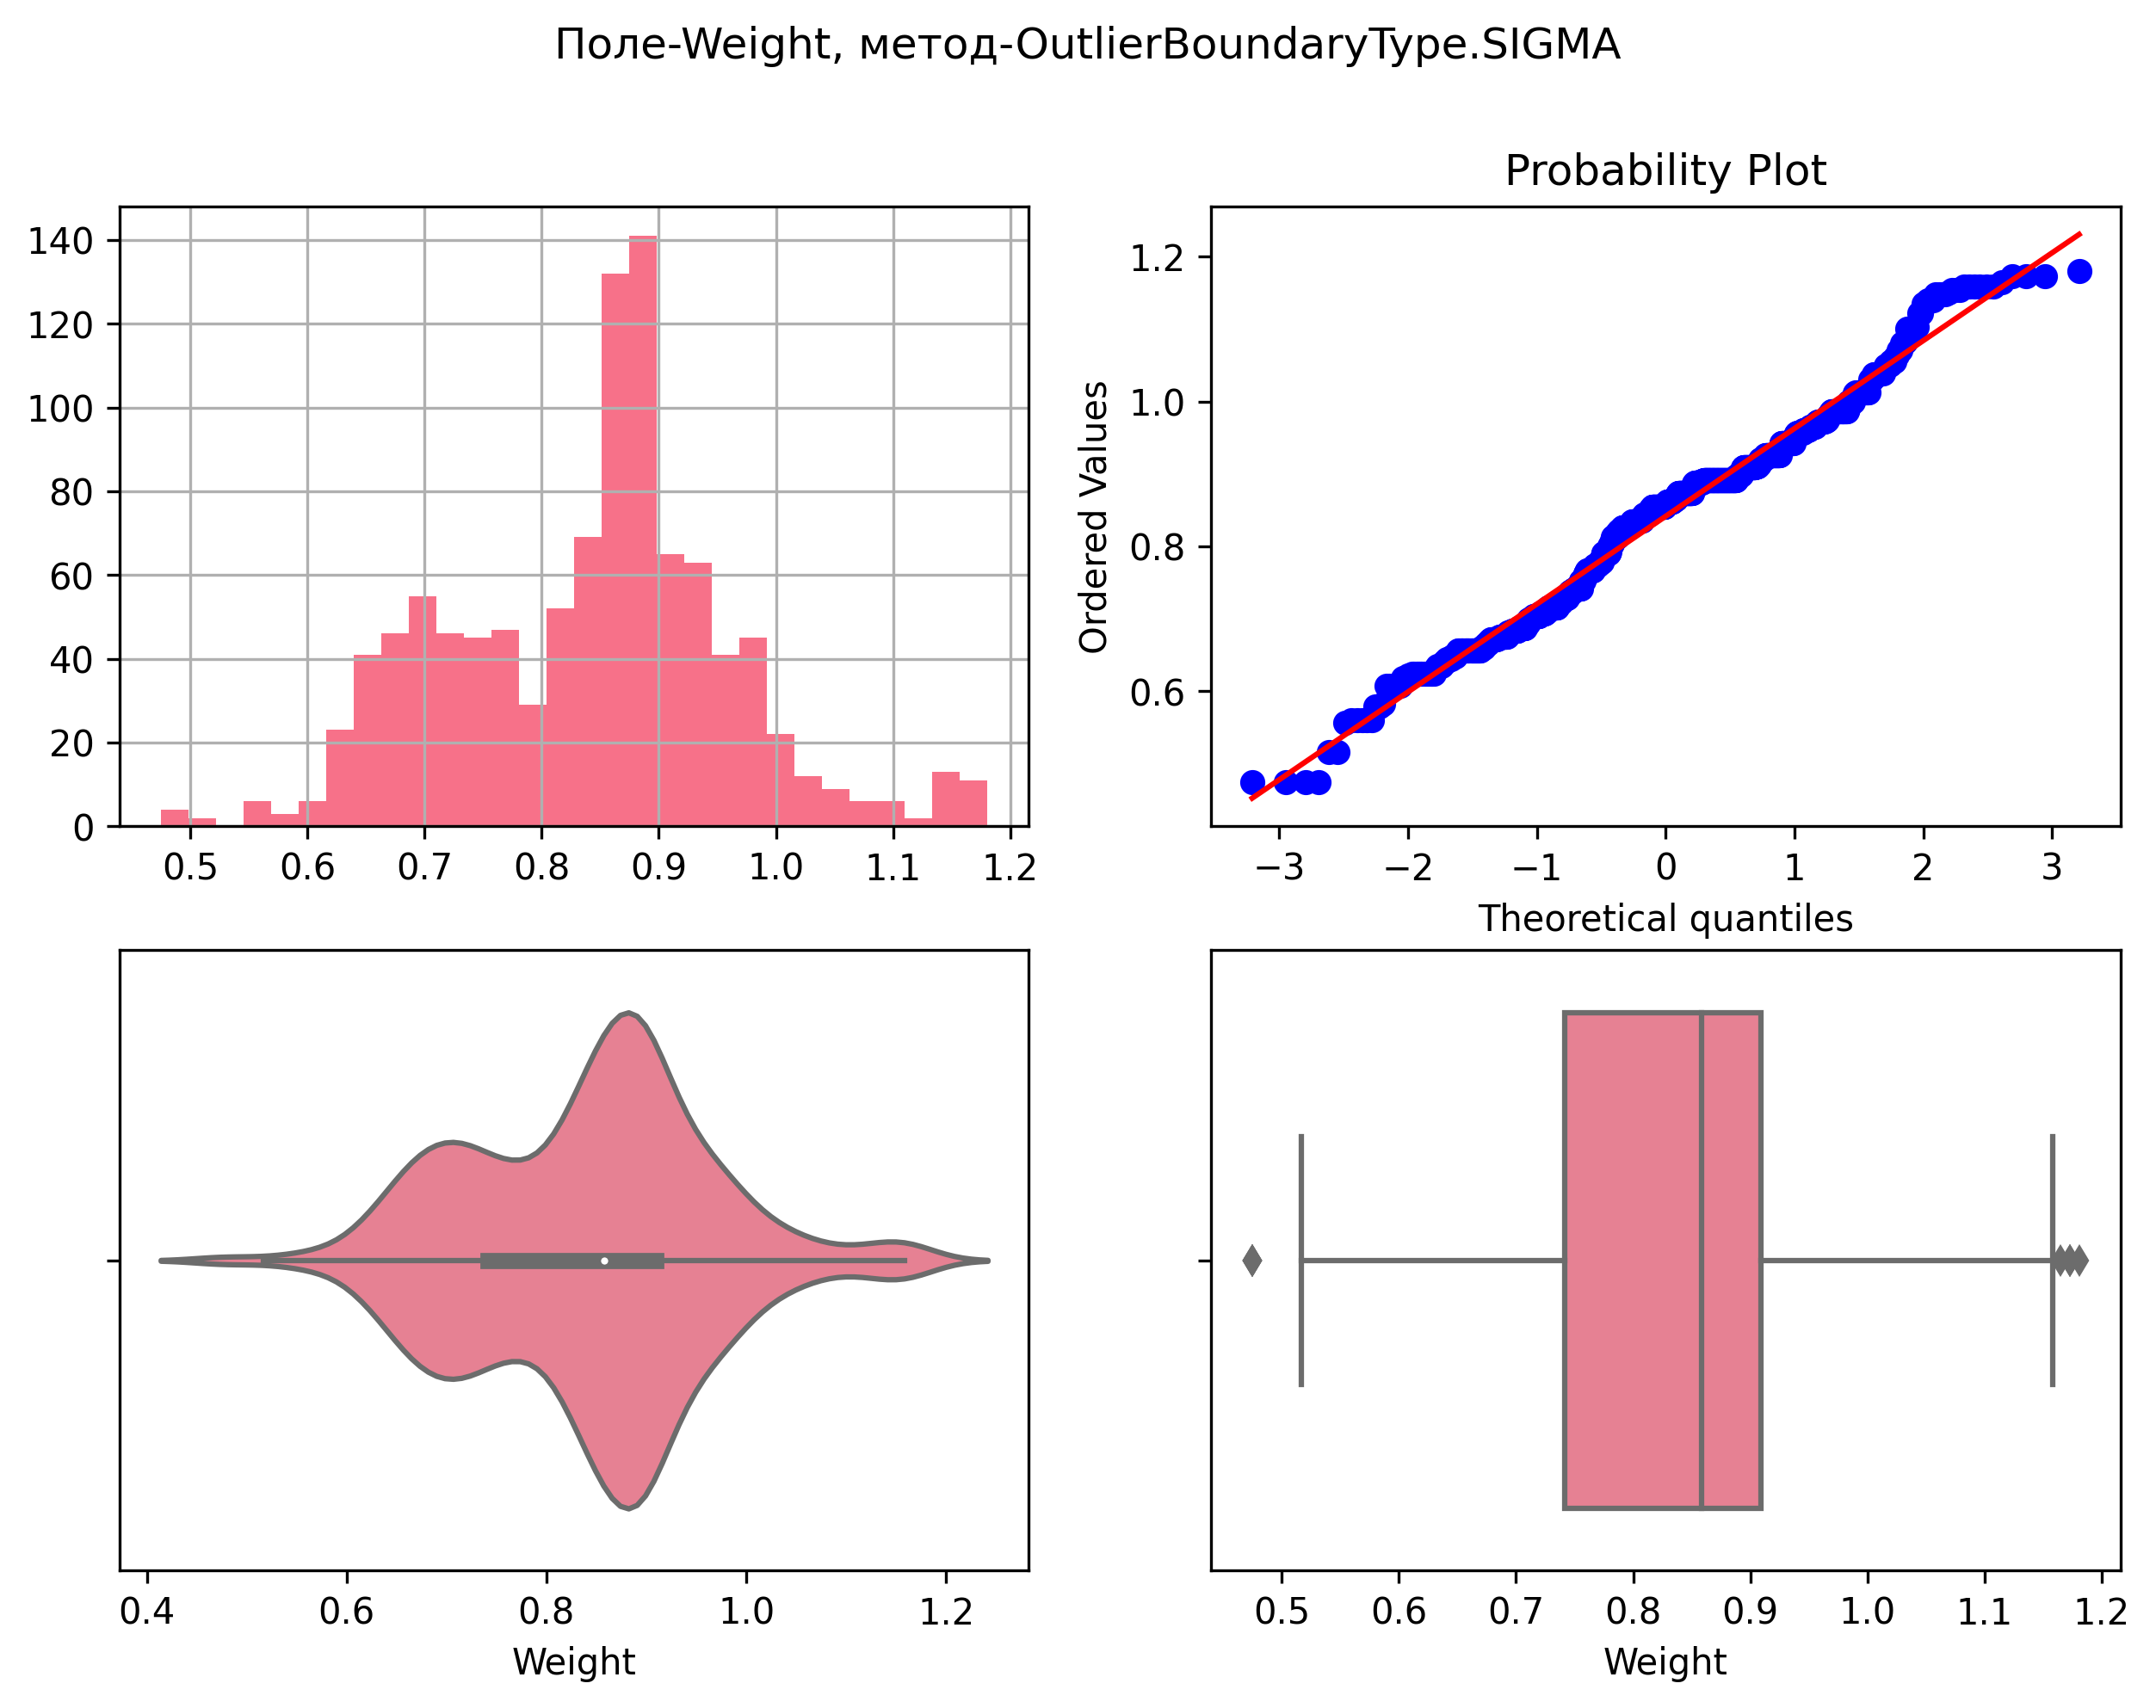

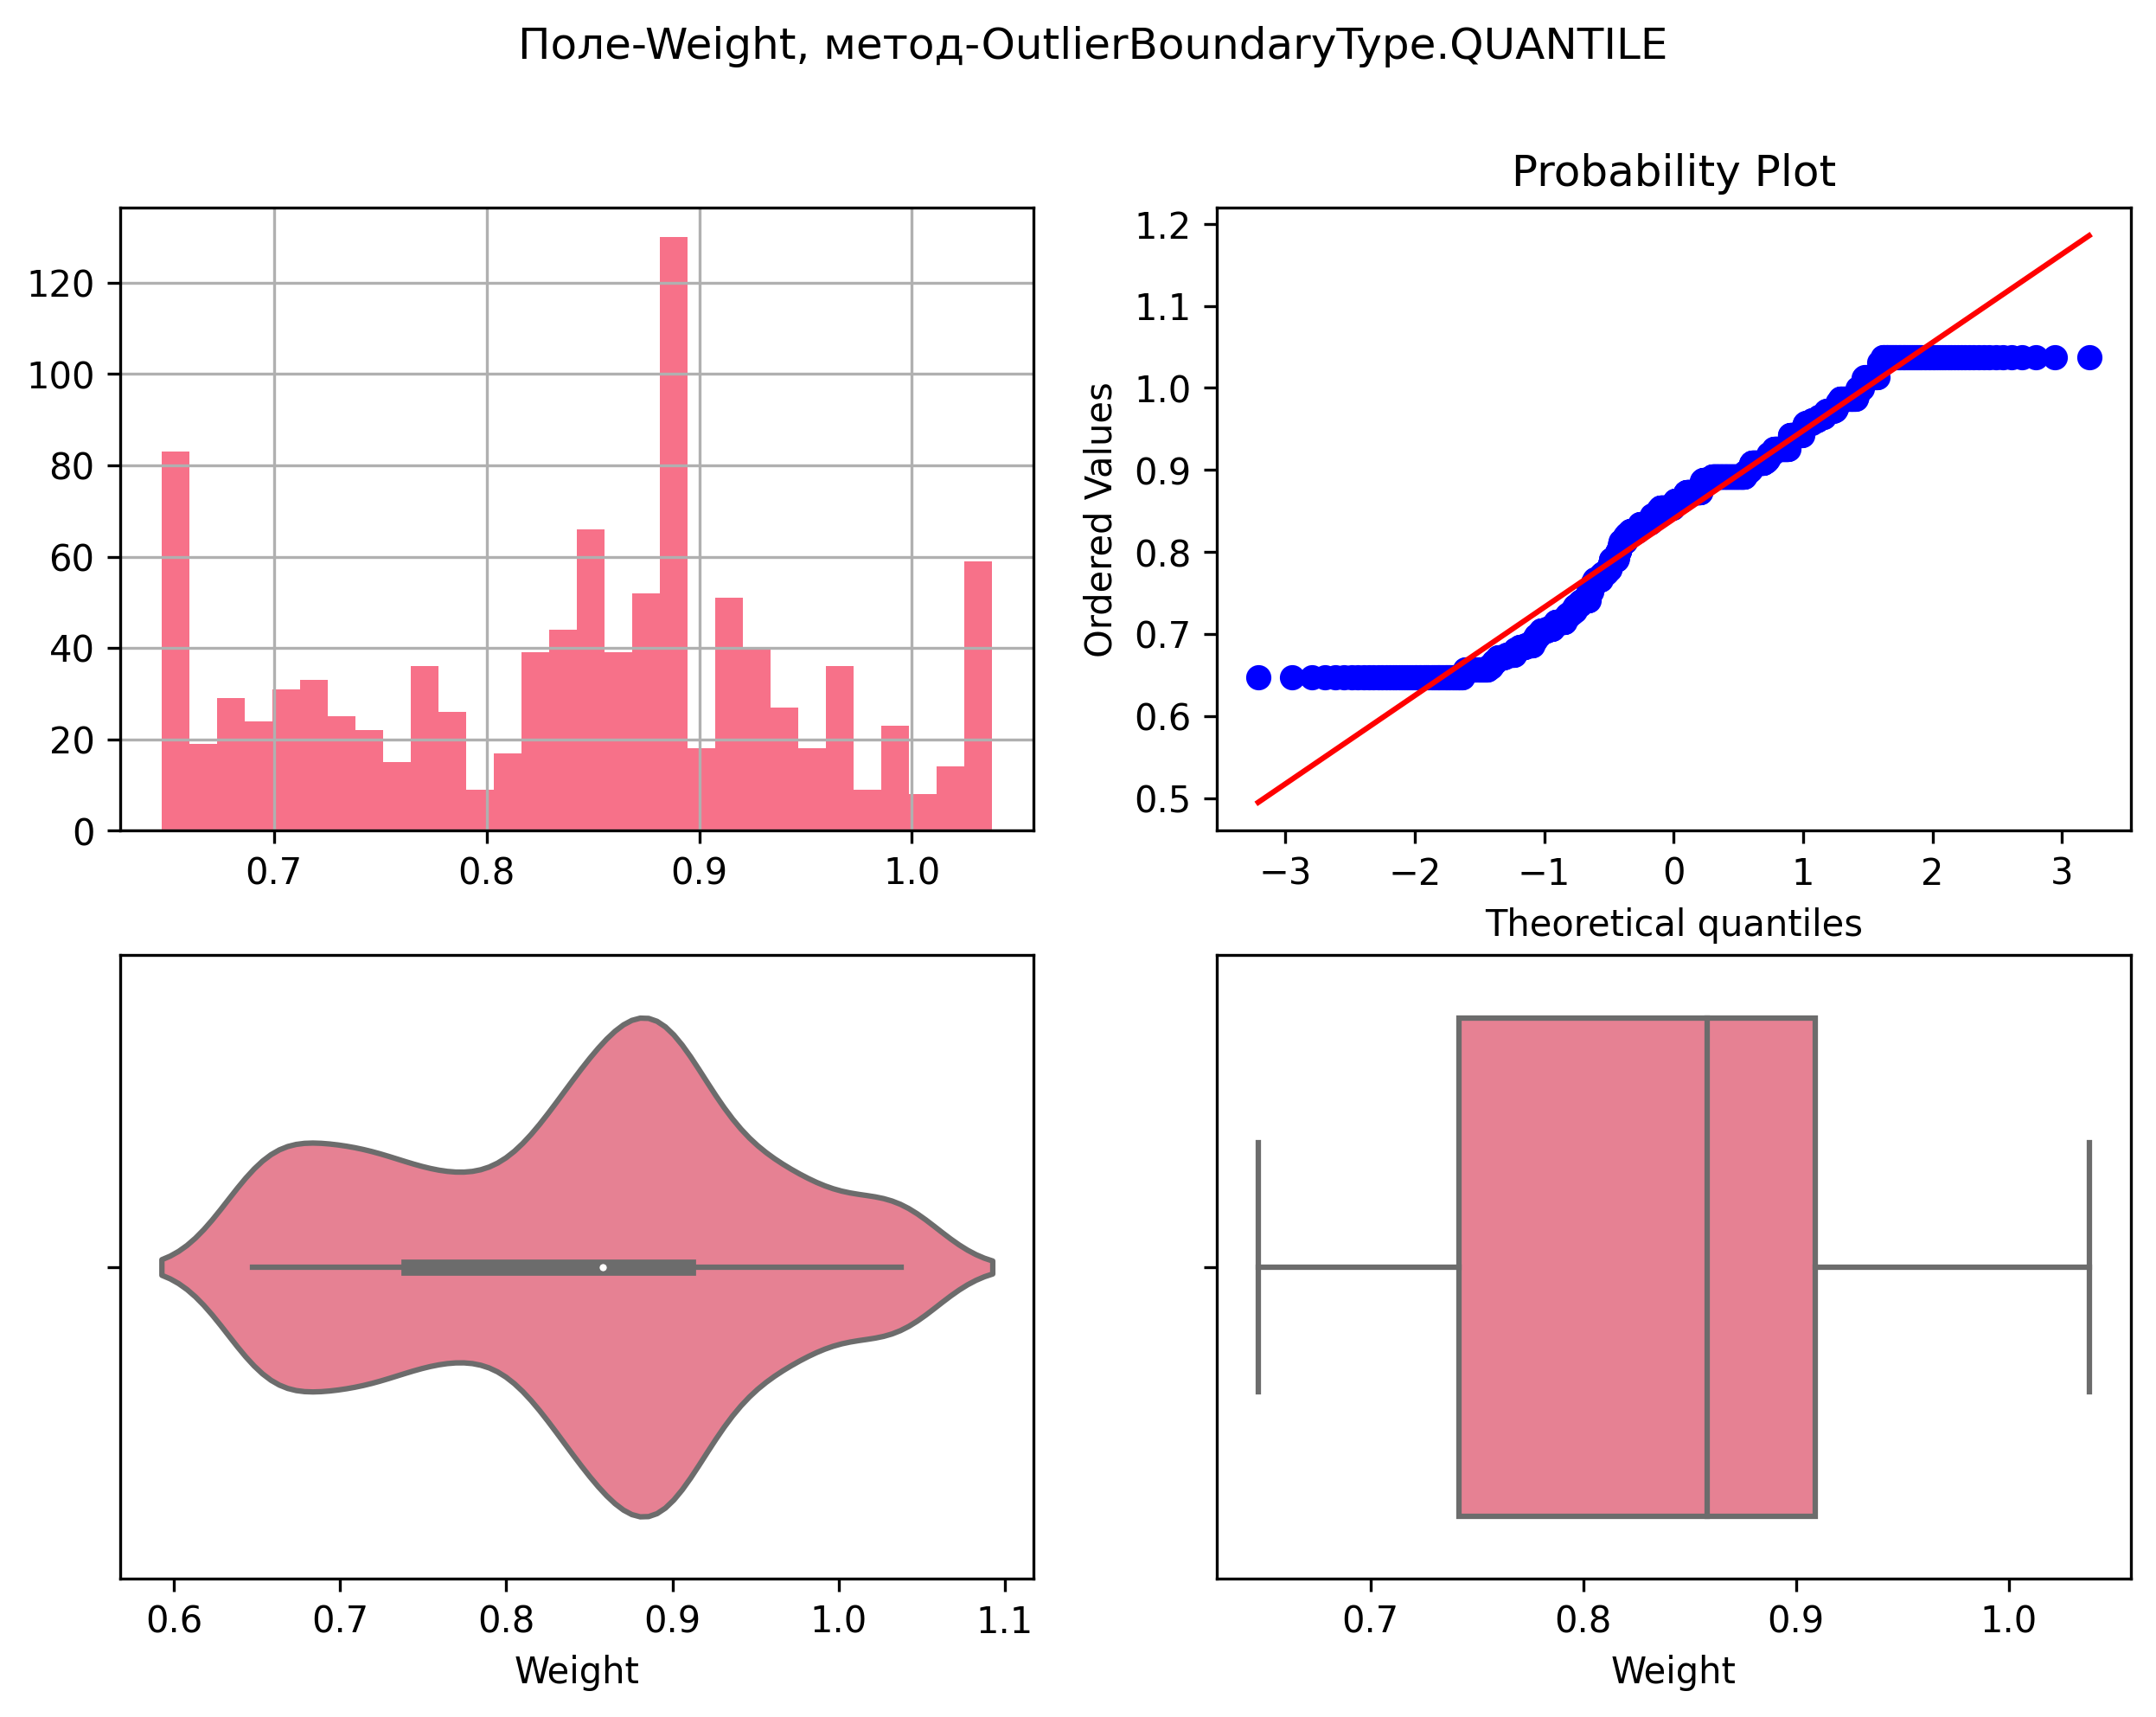

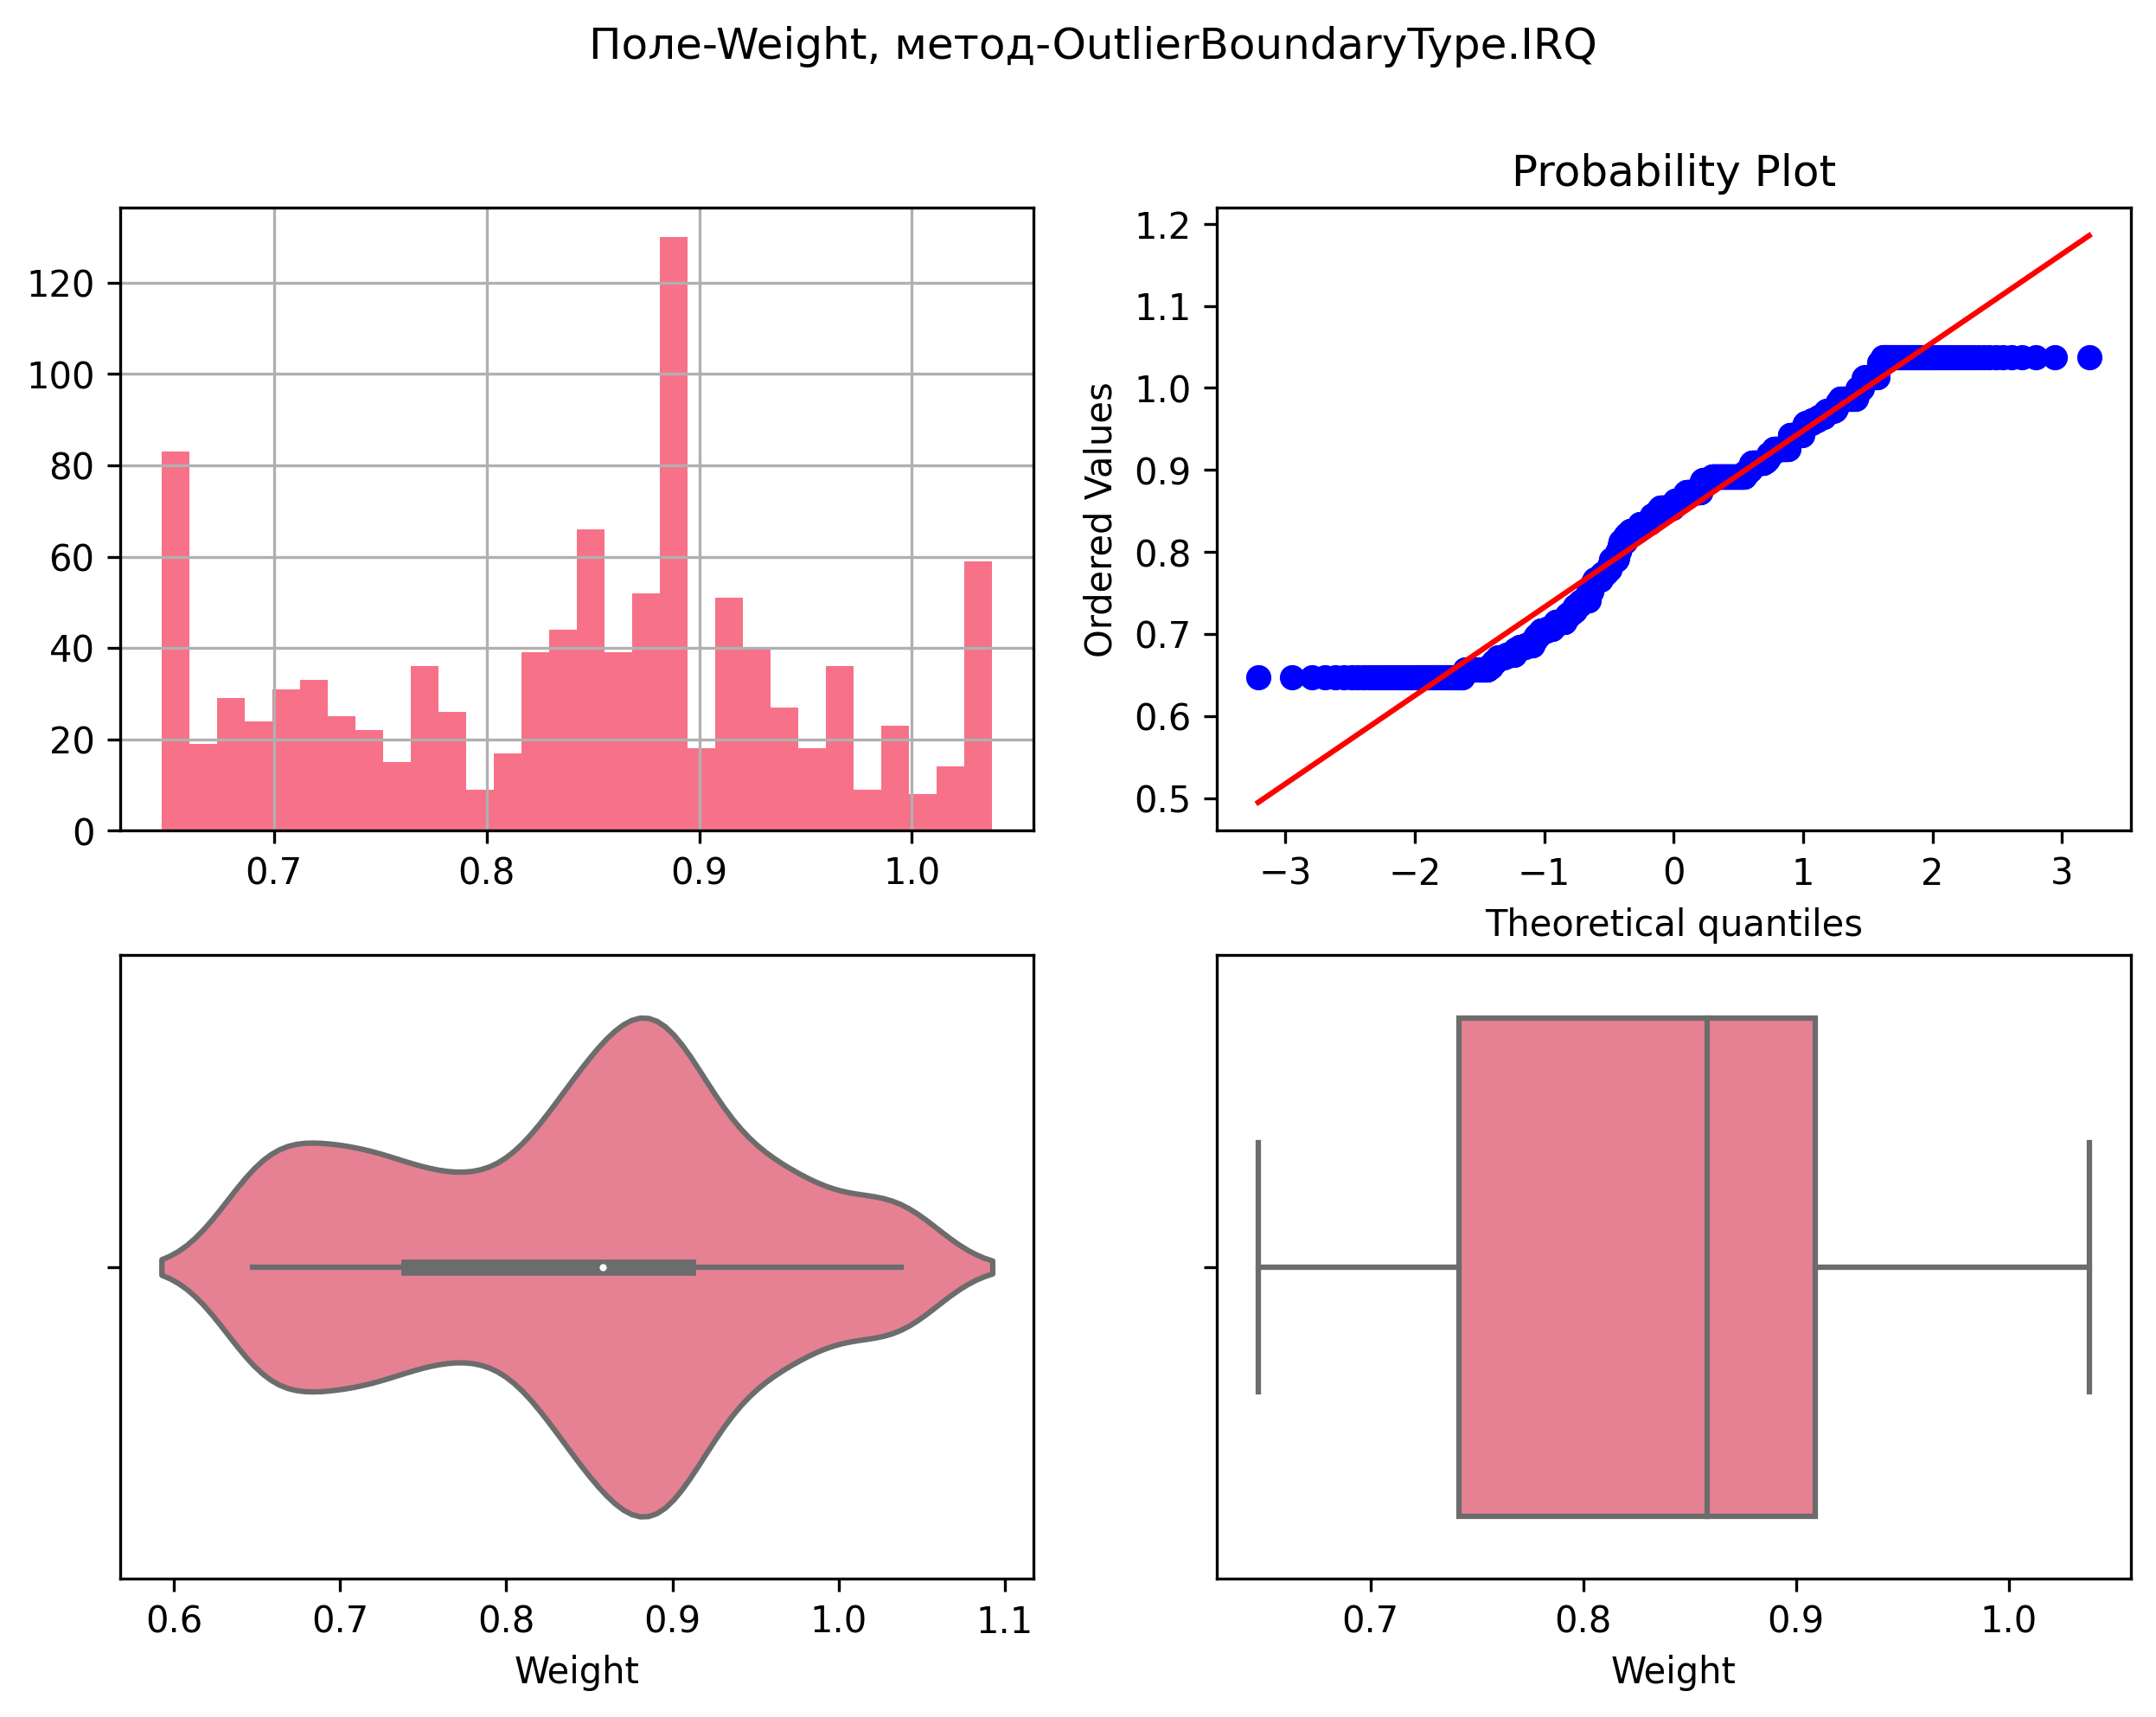

In [27]:
for col in scale_cols:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(X_train, col, obt)
        # Изменение данных
        X_train[col] = np.where(X_train[col] > upper_boundary, upper_boundary, 
                                 np.where(X_train[col] < lower_boundary, lower_boundary, X_train[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(X_train, col, title)



## Отбор признаков

### Метод из группы методов фильтрации

In [28]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = data.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

make_corr_df(data)

,f1,f2,corr
0,Y_res,X_res,0.994219
1,X_res,Y_res,0.994219
2,X_res,ScreenResolution,0.982492
3,ScreenResolution,X_res,0.982492
4,Y_res,ScreenResolution,0.979294
5,ScreenResolution,Y_res,0.979294
6,PPI,Y_res,0.939363
7,Y_res,PPI,0.939363
8,PPI,X_res,0.931217
9,X_res,PPI,0.931217


In [29]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

corr_groups(make_corr_df(data))

[['X_res', 'ScreenResolution', 'PPI', 'Y_res'],
 ['HDD', 'Memory'],
 ['Weight', 'Inches']]

### Метод из группы методов обертывания

In [30]:
sfs = SFS(LinearRegression(),
          k_features=5,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

sfs.fit(X_train, y_train)
sfs.k_feature_names_

('Cpu', 'Ram', 'OpSys', 'SSD', 'Y_res')

### Метод из группы методов вложений

In [31]:
# Используем L1-регуляризацию
e_ls1 = Lasso(random_state=1)
e_ls1.fit(X_train, y_train)
# Коэффициенты регрессии
list(zip(data.drop('Price_euros', axis=1).columns, e_ls1.coef_))

sel_e_ls1 = SelectFromModel(e_ls1)
sel_e_ls1.fit(X_train, y_train)
list(zip(data.drop('Price_euros', axis=1).columns, sel_e_ls1.get_support()))

[('Company', True),
 ('Product', True),
 ('TypeName', True),
 ('Inches', True),
 ('ScreenResolution', True),
 ('Cpu', True),
 ('Ram', True),
 ('Memory', True),
 ('Gpu', True),
 ('OpSys', True),
 ('Weight', False),
 ('HDD', True),
 ('SSD', True),
 ('Hybrid', True),
 ('Flash_Storage', True),
 ('X_res', True),
 ('Y_res', True),
 ('PPI', True)]

In [32]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [33]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [34]:
X_data_dict = {'Basic': (X_train_df, X_test_df)}

In [35]:
def test_models(clas_models_dict, X_train, X_test, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        logger.add(model_name, 'Basic', mse)
            
    return logger



logger = test_models(clas_models_dict, X_train_df, X_test_df, y_train, y_test)

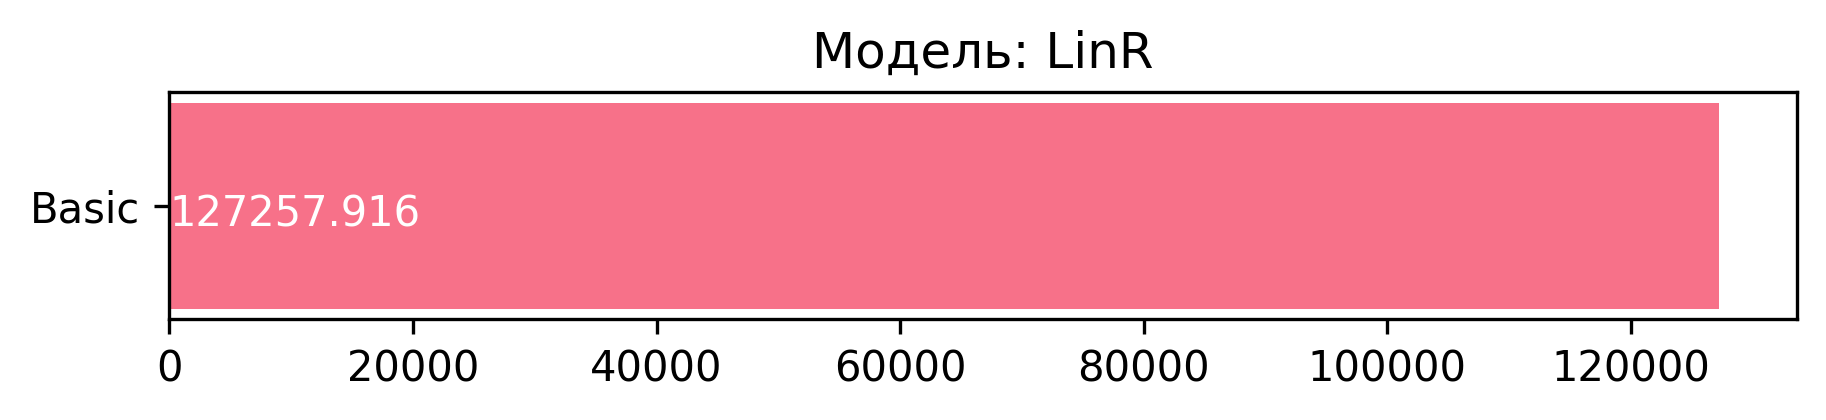

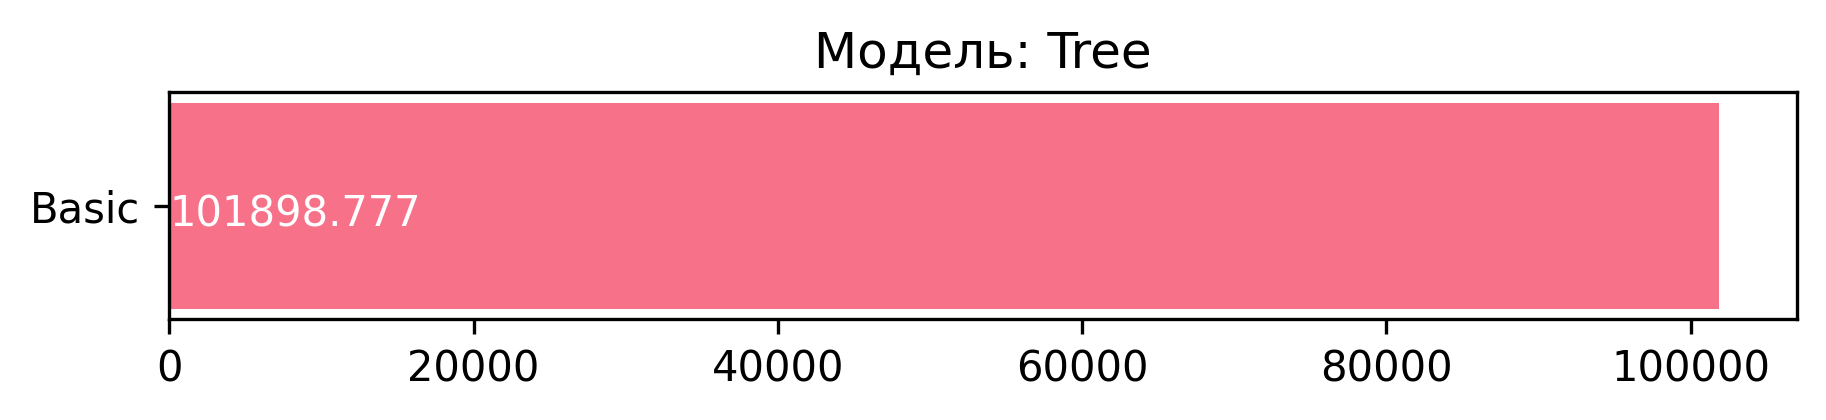

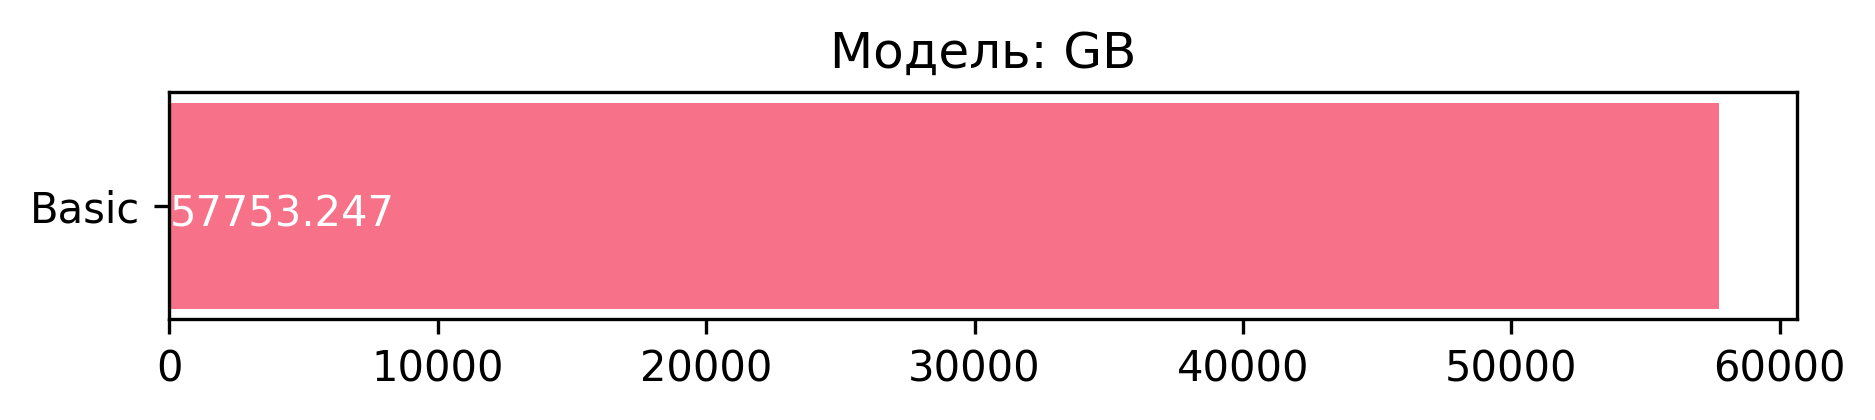

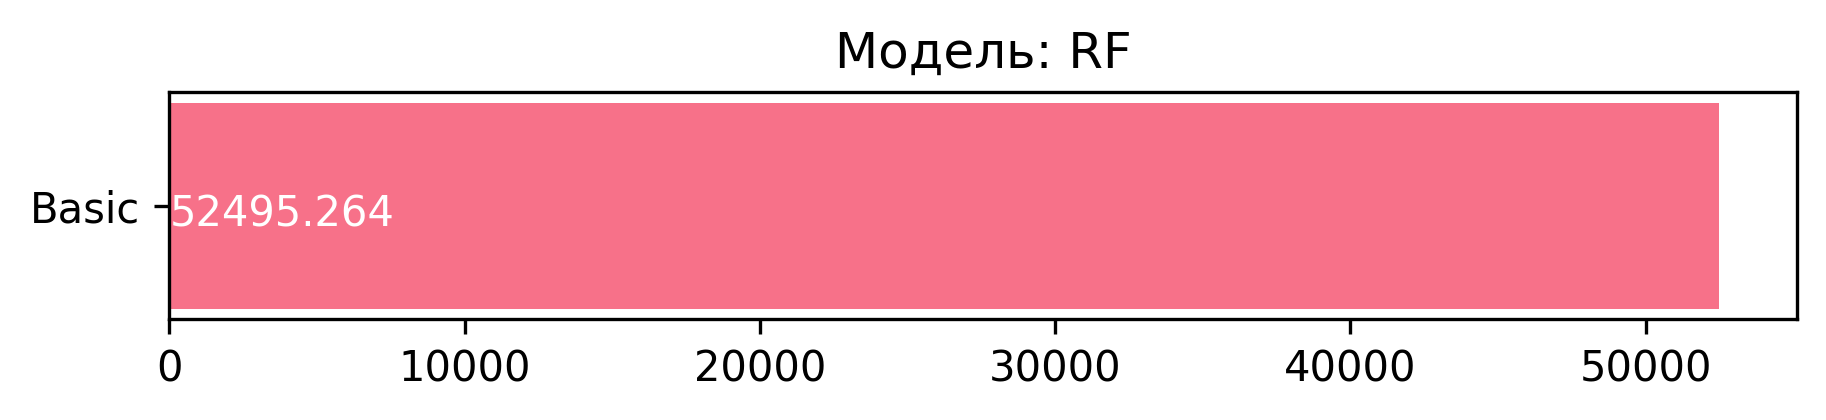

In [36]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 1))

## AutoML

In [98]:
!pip3 install --user mljar-supervised
!pip3 install delayed

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
     |████████████████████████████████| 72 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [99]:
train = data
train.head()

automl = AutoML()
automl.fit(train[train.columns[2:-3]], train['Price_euros'])

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 757.134561 trained in 0.46 seconds
2_DecisionTree rmse 165.431313 trained in 40.07 seconds
3_Linear rmse 1808.228924 trained in 7.19 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 48.712868 trained in 5.95 seconds
5_Default_NeuralNetwork rmse 115.24174 trained in 0.92 seconds
6_Default_RandomForest rmse 104.533224 trained in 5.1 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 37.127632 trained in 0.26 seconds
AutoML fit time: 95.75 seconds
AutoML best model: Ensemble


AutoML()